In [1]:
# Predicting the Key Influencers for the 2024 MLB Season
# Jordan S Richman
# 2024 Project start 11/15/2023

import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import r2_score
import seaborn as sns
import sys
from IPython.display import display, Image

In [2]:
data2023 = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\expected_stats_2023_new.csv', encoding='utf-8')
data2022 = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\expected_stats_2022_new.csv', encoding='utf-8')
data2021 = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\expected_stats_2021_new.csv', encoding='utf-8')
exitdata2023 = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\exit_velocity_2023_new.csv', encoding='utf-8')
exitdata2022 = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\exit_velocity_2022_new.csv', encoding='utf-8')
exitdata2021 = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\exit_velocity_2021_new.csv', encoding='utf-8')

# Merge the datasets based on 'player_id' for each year
merged_data2023 = pd.merge(data2023, exitdata2023, on='player_id')
merged_data2022 = pd.merge(data2022, exitdata2022, on='player_id')
merged_data2021 = pd.merge(data2021, exitdata2021, on='player_id')

# Combine the merged datasets into a single dataframe
all_data = pd.concat([merged_data2023, merged_data2022, merged_data2021])

# Resetting the index to avoid any issues
all_data.reset_index(drop=True, inplace=True)

# Drop the original columns of unneeded columns/ dup columns
# Adding new columns to use in Regression with simple calculations to get xOPS and xISO
all_data.drop(['year_y'], axis=1, inplace=True)
all_data.drop(['player_name_y'], axis=1, inplace=True)
all_data.rename(columns={'player_name_x': 'player_name'}, inplace=True)
all_data.rename(columns={'year_x': 'year'}, inplace=True)
all_data['est_ops'] = all_data['est_woba'] + all_data['est_slg']
all_data['est_iso'] = all_data['est_slg'] - all_data['est_ba']

Mean Squared Error for xWOBA: 0.00013935216840917937


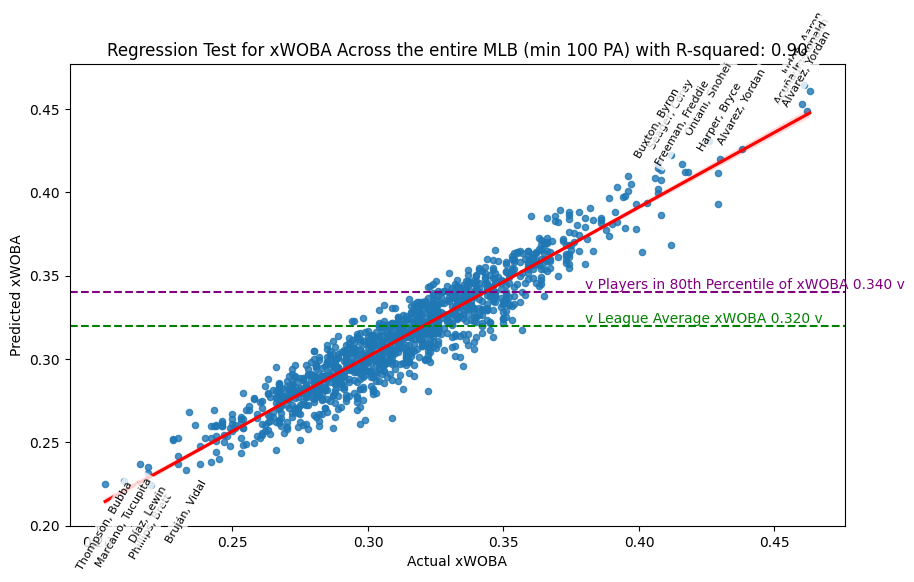

In [3]:
# First Regression Test on xWOBA.
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
X = all_data[['year', 'player_label', 'est_ba', 'brl_pa', 'est_slg']]
y = all_data['est_woba']

# Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Add a new column for predicted est_woba using features of xBatting Average, barrels per plate appearance, and xSLG
all_data['predicted_est_woba(advanced)'] = model.predict(X)

# Evaluate the model (you can replace this with your own evaluation metrics)
mse = mean_squared_error(y, all_data['predicted_est_woba(advanced)'])
print(f'Mean Squared Error for xWOBA: {mse}')

top_players = all_data.nlargest(10, 'predicted_est_woba(advanced)')
bottom_players = all_data.nsmallest(5, 'predicted_est_woba(advanced)')

plt.figure(figsize=(10, 6))
sns.regplot(x='est_woba', y='predicted_est_woba(advanced)', data=all_data, scatter_kws={'s': 20},
            line_kws={'color': 'red'})

# Plot league average xwoba as a straight line
# plt.axvline(x=league_average_xwoba, color='green', linestyle='--', label='League Average xWOBA')
league_average_xwoba = 0.320
plt.axhline(y=league_average_xwoba, color='green', linestyle='--', label='League Average xWOBA')
percentile_80 = np.percentile(all_data['predicted_est_woba(advanced)'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of xWOBA')

# Calculate and display R-squared
r_squared = r2_score(y, all_data['predicted_est_woba(advanced)'])
plt.title(f'Regression Test for xWOBA Across the entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual xWOBA')
plt.ylabel('Predicted xWOBA')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['est_woba'], player['predicted_est_woba(advanced)']),
                 textcoords="offset points", xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['est_woba'], player['predicted_est_woba(advanced)']),
                 textcoords="offset points", xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Display the percentage on the graph
plt.text(0.38, percentile_80, f'v Players in 80th Percentile of xWOBA {percentile_80:.3f} v', color='purple', ha='left',
         va='bottom', fontsize=10)
plt.text(0.38, league_average_xwoba, f'v League Average xWOBA {league_average_xwoba:.3f} v', color='green', ha='left',
         va='bottom', fontsize=10)

plt.show()

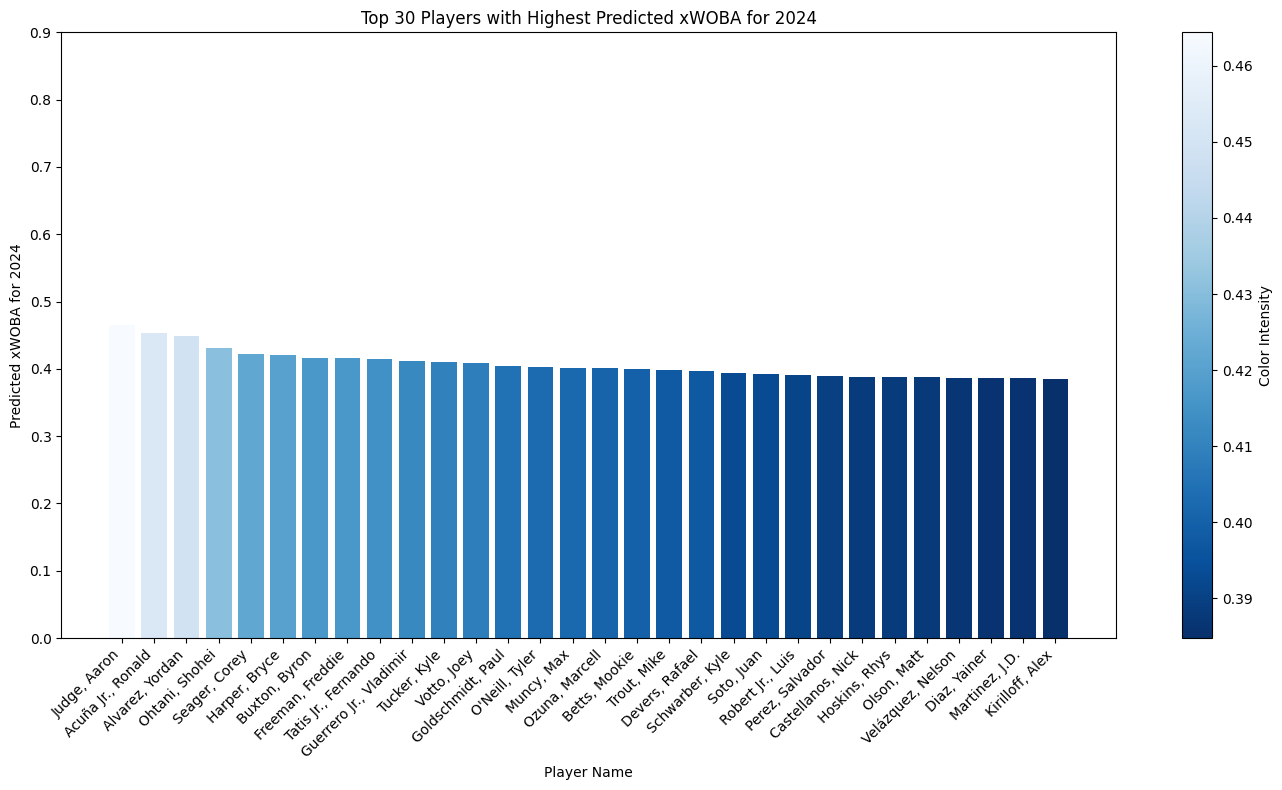

In [4]:
# ---Bar chart of the top predicted xWOBA for 2024--------------------------------------------------------------------

# Closer look at the top 10 leaders in expected 2024 xWOBA
# Sort the DataFrame by 'predicted_woba_2024' in descending order
top_players = all_data.sort_values(by='predicted_est_woba(advanced)', ascending=False).drop_duplicates(
    'player_name').head(30)

cmap = cm.get_cmap('Blues_r')

# Reverse the normalization to have dark colors for higher values
norm = colors.Normalize(vmin=top_players['predicted_est_woba(advanced)'].min(),
                        vmax=top_players['predicted_est_woba(advanced)'].max())

# Create a ScalarMappable with the colormap and reversed normalization
sm = cm.ScalarMappable(cmap=cmap, norm=norm)

# Create a bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(top_players['player_name'], top_players['predicted_est_woba(advanced)'],
               color=cmap(norm(top_players['predicted_est_woba(advanced)'])))
plt.xlabel('Player Name')
plt.ylabel('Predicted xWOBA for 2024')
plt.title('Top 30 Players with Highest Predicted xWOBA for 2024')
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 1.0, 0.1))

# Add color bar for better interpretation
cbar = plt.colorbar(sm, label='Color Intensity')

plt.tight_layout()
plt.show()

Mean Squared Error for xBA: 0.00010248160640505285


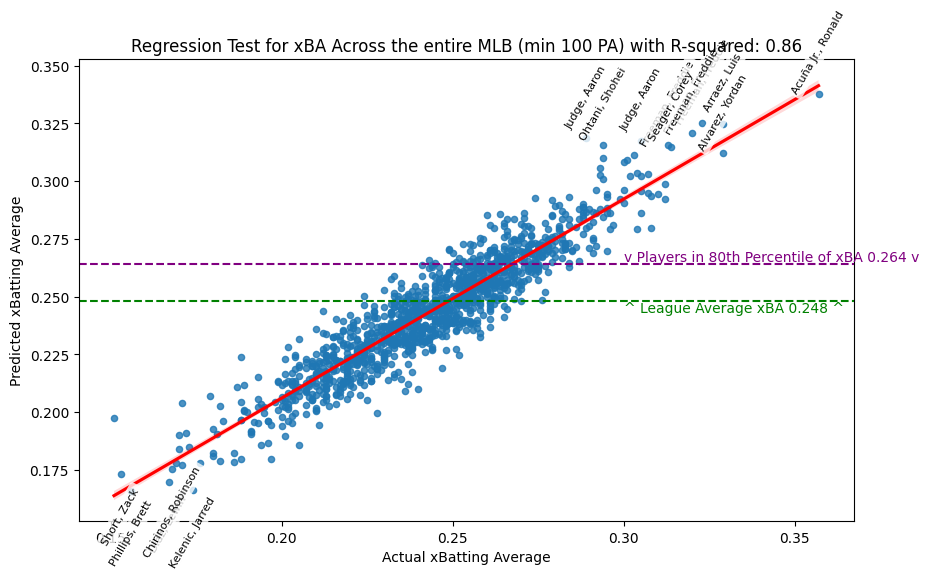

In [5]:
# Regression Test on xBA.
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
W = all_data[['year', 'player_label', 'ba', 'brl_pa', 'est_slg']]
z = all_data['est_ba']

# Train a linear regression model
model = LinearRegression()
model.fit(W, z)

# Add a new column for predicted est_woba using features of Batting Average, barrels per plate appearance, and xSLG
all_data['predicted_est_ba'] = model.predict(W)

# Evaluate the model
mse = mean_squared_error(z, all_data['predicted_est_ba'])
print(f'Mean Squared Error for xBA: {mse}')

top_players = all_data.nlargest(10, 'predicted_est_ba')
bottom_players = all_data.nsmallest(5, 'predicted_est_ba')

plt.figure(figsize=(10, 6))
sns.regplot(x='est_ba', y='predicted_est_ba', data=all_data, scatter_kws={'s': 20}, line_kws={'color': 'red'})

league_average_xba = 0.248
plt.axhline(y=league_average_xba, color='green', linestyle='--', label='League Average xBA')
percentile_80 = np.percentile(all_data['predicted_est_ba'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of xBA')

# Calculate and display R-squared
r_squared = r2_score(z, all_data['predicted_est_ba'])
plt.title(f'Regression Test for xBA Across the entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual xBatting Average')
plt.ylabel('Predicted xBatting Average')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['est_ba'], player['predicted_est_ba']), textcoords="offset points",
                 xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['est_ba'], player['predicted_est_ba']), textcoords="offset points",
                 xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(0.30, percentile_80, f'v Players in 80th Percentile of xBA {percentile_80:.3f} v', color='purple', ha='left',
         va='bottom', fontsize=10)
plt.text(0.30, league_average_xba, f'^ League Average xBA {league_average_xba:.3f} ^', color='green', ha='left',
         va='top', fontsize=10)

plt.show()

Mean Squared Error for xSLG: 0.0010122205741723686


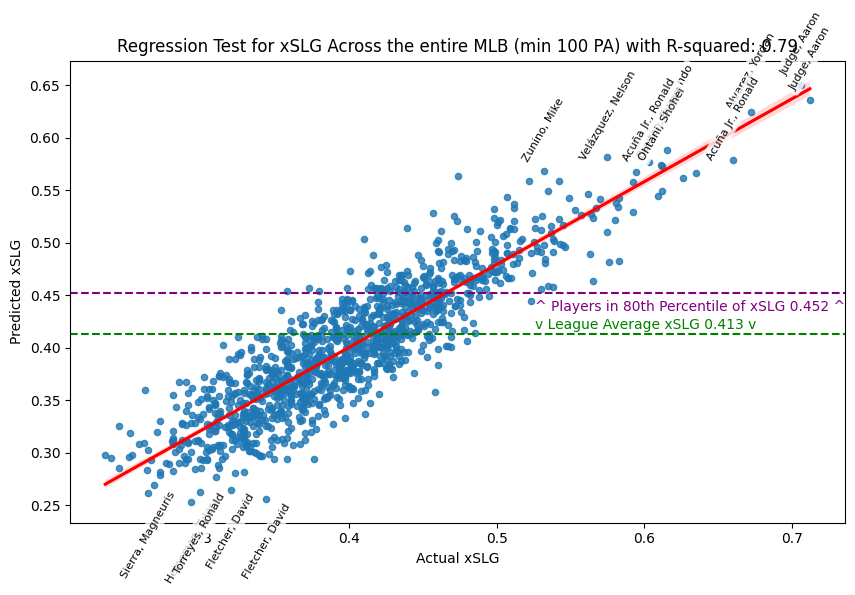

In [6]:
# Regression Test on xSLG.
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
A = all_data[['year', 'player_label', 'avg_hit_angle', 'avg_hit_speed', 'brl_pa']]
b = all_data['est_slg']

# Train a linear regression model
model = LinearRegression()
model.fit(A, b)

# Add a new column for predicted est_woba using features of Avg Hit Angle, barrels per plate appearanc, and Avg Hit Speed
all_data['predicted_est_slg'] = model.predict(A)

# Evaluate the model
mse = mean_squared_error(b, all_data['predicted_est_slg'])
print(f'Mean Squared Error for xSLG: {mse}')

top_players = all_data.nlargest(10, 'predicted_est_slg')
bottom_players = all_data.nsmallest(5, 'predicted_est_slg')

plt.figure(figsize=(10, 6))
sns.regplot(x='est_slg', y='predicted_est_slg', data=all_data, scatter_kws={'s': 20}, line_kws={'color': 'red'})

league_average_xslg = 0.413
plt.axhline(y=league_average_xslg, color='green', linestyle='--', label='League Average xSLG')
percentile_80 = np.percentile(all_data['predicted_est_slg'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of xSLG')

# Calculate and display R-squared
r_squared = r2_score(b, all_data['predicted_est_slg'])
plt.title(f'Regression Test for xSLG Across the entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual xSLG')
plt.ylabel('Predicted xSLG')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['est_slg'], player['predicted_est_slg']), textcoords="offset points",
                 xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['est_slg'], player['predicted_est_slg']), textcoords="offset points",
                 xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(0.60, percentile_80, f'^ Players in 80th Percentile of xSLG {percentile_80:.3f} ^', color='purple', ha='left',
         va='bottom', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.60, league_average_xslg, f'v League Average xSLG {league_average_xslg:.3f} v', color='green', ha='left',
         va='bottom', fontsize=10, transform=plt.gca().transAxes)

plt.show()

Mean Squared Error for Barrels per Plate Appearance: 2.0707107526375803


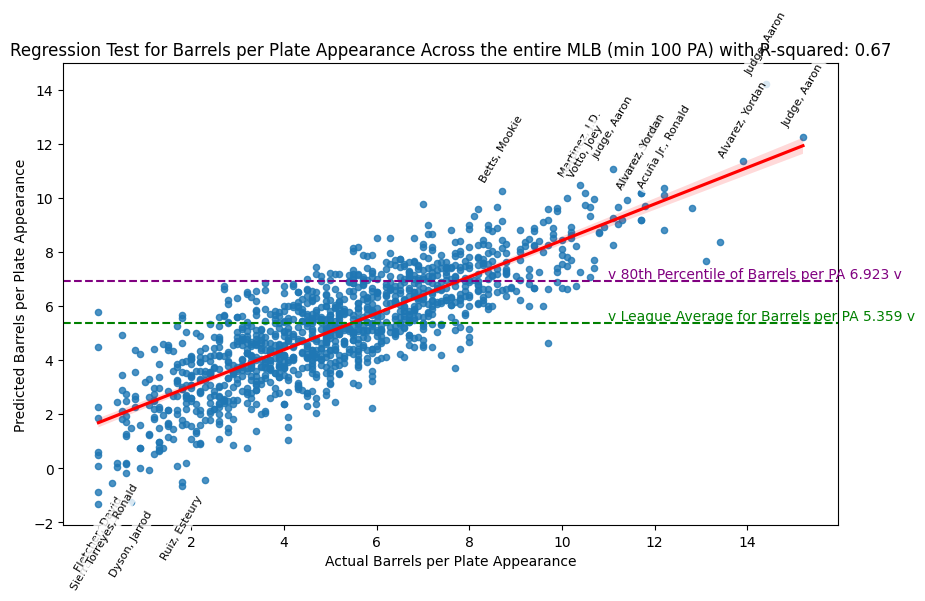

In [7]:
# Regression Test on Barrel per Plate Appearance.
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
C = all_data[['year', 'player_label', 'avg_hit_angle', 'avg_hit_speed', 'avg_distance']]
d = all_data['brl_pa']

# Train a linear regression model
model = LinearRegression()
model.fit(C, d)

# Add a new column for predicted est_woba using features of Avg Hit Angle, Avg Hit Speed, and Avg Hit Distance
all_data['predicted_brl_pa'] = model.predict(C)

# Evaluate the model 
mse = mean_squared_error(d, all_data['predicted_brl_pa'])
print(f'Mean Squared Error for Barrels per Plate Appearance: {mse}')

top_players = all_data.nlargest(10, 'predicted_brl_pa')
bottom_players = all_data.nsmallest(5, 'predicted_brl_pa')

plt.figure(figsize=(10, 6))
sns.regplot(x='brl_pa', y='predicted_brl_pa', data=all_data, scatter_kws={'s': 20}, line_kws={'color': 'red'})

league_average_brl_pa = all_data[all_data['year'] == 2023]['brl_pa'].mean()
plt.axhline(y=league_average_brl_pa, color='green', linestyle='--', label='League Average Barrels per PA')
percentile_80 = np.percentile(all_data['predicted_brl_pa'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of Barrels per PA')

# Calculate and display R-squared
r_squared = r2_score(d, all_data['predicted_brl_pa'])
plt.title(
    f'Regression Test for Barrels per Plate Appearance Across the entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual Barrels per Plate Appearance')
plt.ylabel('Predicted Barrels per Plate Appearance')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['brl_pa'], player['predicted_brl_pa']), textcoords="offset points",
                 xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['brl_pa'], player['predicted_brl_pa']), textcoords="offset points",
                 xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(11.00, percentile_80, f'v 80th Percentile of Barrels per PA {percentile_80:.3f} v', color='purple', ha='left',
         va='bottom', fontsize=10)
plt.text(11.00, league_average_brl_pa, f'v League Average for Barrels per PA {league_average_brl_pa:.3f} v',
         color='green', ha='left', va='bottom', fontsize=10)

plt.show()

Mean Squared Error for Average Hit Angle: 14.983203335678141


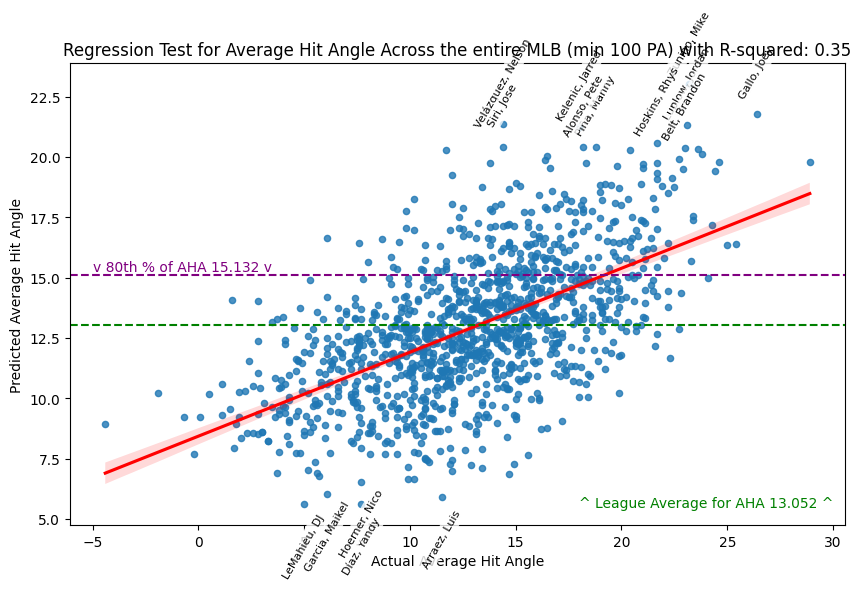

In [8]:
# Regression Test on Average Hit Angle.
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
E = all_data[['year', 'player_label', 'est_ba', 'avg_hit_speed', 'est_slg']]
f = all_data['avg_hit_angle']

# Train a linear regression model
model = LinearRegression()
model.fit(E, f)

# Add a new column for predicted est_woba using features of xBatting Average, Avg Hit Speed, and xSLG
all_data['predicted_avg_hit_angle'] = model.predict(E)

# Evaluate the model
mse = mean_squared_error(f, all_data['predicted_avg_hit_angle'])
print(f'Mean Squared Error for Average Hit Angle: {mse}')

top_players = all_data.nlargest(10, 'predicted_avg_hit_angle')
bottom_players = all_data.nsmallest(5, 'predicted_avg_hit_angle')

plt.figure(figsize=(10, 6))
sns.regplot(x='avg_hit_angle', y='predicted_avg_hit_angle', data=all_data, scatter_kws={'s': 20},
            line_kws={'color': 'red'})

league_average_avg_hit_angle = all_data[all_data['year'] == 2023]['avg_hit_angle'].mean()
plt.axhline(y=league_average_avg_hit_angle, color='green', linestyle='--', label='League Average Average Hit Angle')
percentile_80 = np.percentile(all_data['predicted_avg_hit_angle'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of Average Hit Angle')

# Calculate and display R-squared
r_squared = r2_score(f, all_data['predicted_avg_hit_angle'])
plt.title(f'Regression Test for Average Hit Angle Across the entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual Average Hit Angle')
plt.ylabel('Predicted Average Hit Angle')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['avg_hit_angle'], player['predicted_avg_hit_angle']),
                 textcoords="offset points", xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['avg_hit_angle'], player['predicted_avg_hit_angle']),
                 textcoords="offset points", xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(-5.00, percentile_80, f'v 80th % of AHA {percentile_80:.3f} v', color='purple', ha='left', va='bottom',
         fontsize=10)
plt.text(18.00, league_average_brl_pa, f'^ League Average for AHA {league_average_avg_hit_angle:.3f} ^', color='green',
         ha='left', va='bottom', fontsize=10)

plt.show()

Mean Squared Error for Average Hit Speed: 1.896501355276218


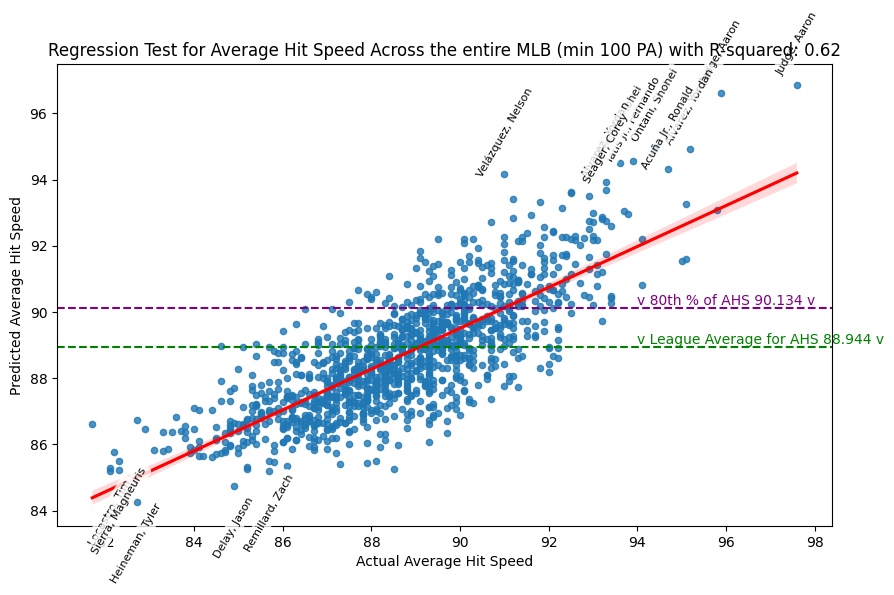

In [9]:
# Regression Test on Average Hit Speed.
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
G = all_data[['year', 'player_label', 'est_ba', 'avg_hit_angle', 'est_slg']]
h = all_data['avg_hit_speed']

# Train a linear regression model
model = LinearRegression()
model.fit(G, h)

# Add a new column for predicted est_woba using features of xBatting Average, Avg Hit Angle, and xSLG
all_data['predicted_avg_hit_speed'] = model.predict(G)

# Evaluate the model
mse = mean_squared_error(h, all_data['predicted_avg_hit_speed'])
print(f'Mean Squared Error for Average Hit Speed: {mse}')

top_players = all_data.nlargest(10, 'predicted_avg_hit_speed')
bottom_players = all_data.nsmallest(5, 'predicted_avg_hit_speed')

plt.figure(figsize=(10, 6))
sns.regplot(x='avg_hit_speed', y='predicted_avg_hit_speed', data=all_data, scatter_kws={'s': 20},
            line_kws={'color': 'red'})

league_average_avg_hit_speed = all_data[all_data['year'] == 2023]['avg_hit_speed'].mean()
plt.axhline(y=league_average_avg_hit_speed, color='green', linestyle='--', label='League Average Average Hit Speed')
percentile_80 = np.percentile(all_data['predicted_avg_hit_speed'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of Average Hit Speed')

# Calculate and display R-squared
r_squared = r2_score(h, all_data['predicted_avg_hit_speed'])
plt.title(f'Regression Test for Average Hit Speed Across the entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual Average Hit Speed')
plt.ylabel('Predicted Average Hit Speed')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['avg_hit_speed'], player['predicted_avg_hit_speed']),
                 textcoords="offset points", xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['avg_hit_speed'], player['predicted_avg_hit_speed']),
                 textcoords="offset points", xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(94.00, percentile_80, f'v 80th % of AHS {percentile_80:.3f} v', color='purple', ha='left', va='bottom',
         fontsize=10)
plt.text(94.00, league_average_avg_hit_speed, f'v League Average for AHS {league_average_avg_hit_speed:.3f} v',
         color='green', ha='left', va='bottom', fontsize=10)

plt.show()

Mean Squared Error for Average Hit Distance: 62.62869053312606


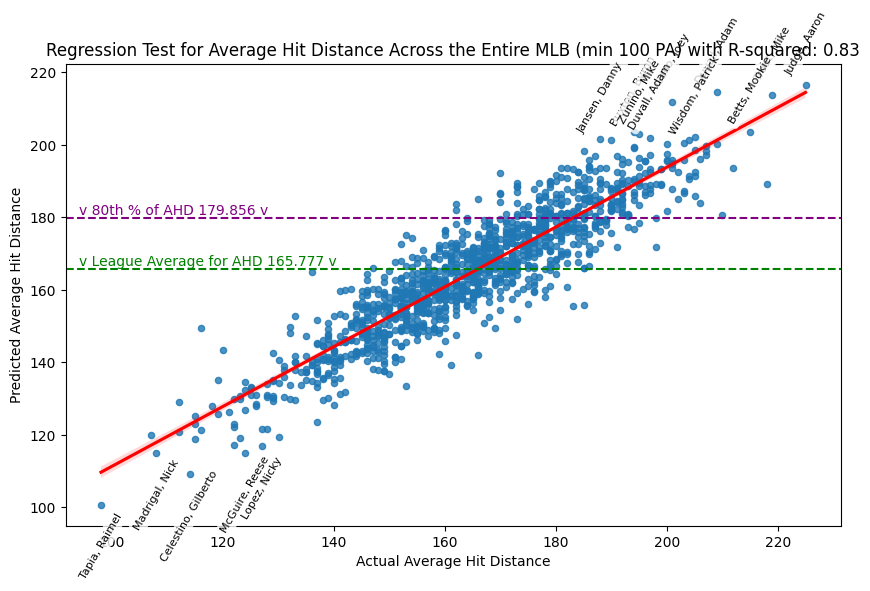

In [10]:
# Regression Test on Average Distance.
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
I = all_data[['year', 'player_label', 'est_ba', 'avg_hit_angle', 'avg_hit_speed']]
j = all_data['avg_distance']

# Train a linear regression model
model = LinearRegression()
model.fit(I, j)

# Add a new column for predicted avg hit distance using features of xBatting Average, Avg Hit Angle, and Avg Hit Speed
all_data['predicted_avg_distance'] = model.predict(I)

# Evaluate the model 
mse = mean_squared_error(j, all_data['predicted_avg_distance'])
print(f'Mean Squared Error for Average Hit Distance: {mse}')

top_players = all_data.nlargest(10, 'predicted_avg_distance')
bottom_players = all_data.nsmallest(5, 'predicted_avg_distance')

plt.figure(figsize=(10, 6))
sns.regplot(x='avg_distance', y='predicted_avg_distance', data=all_data, scatter_kws={'s': 20},
            line_kws={'color': 'red'})

league_average_avg_distance = all_data[all_data['year'] == 2023]['avg_distance'].mean()
plt.axhline(y=league_average_avg_distance, color='green', linestyle='--', label='League Average Average Hit Distance')
percentile_80 = np.percentile(all_data['predicted_avg_distance'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of Average Hit Distance')

# Calculate and display R-squared
r_squared = r2_score(j, all_data['predicted_avg_distance'])
plt.title(
    f'Regression Test for Average Hit Distance Across the Entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual Average Hit Distance')
plt.ylabel('Predicted Average Hit Distance')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['avg_distance'], player['predicted_avg_distance']),
                 textcoords="offset points", xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['avg_distance'], player['predicted_avg_distance']),
                 textcoords="offset points", xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(94.00, percentile_80, f'v 80th % of AHD {percentile_80:.3f} v', color='purple', ha='left', va='bottom',
         fontsize=10)
plt.text(94.00, league_average_avg_distance, f'v League Average for AHD {league_average_avg_distance:.3f} v',
         color='green', ha='left', va='bottom', fontsize=10)

plt.show()

Mean Squared Error for xOPS: 0.0006422997398363399


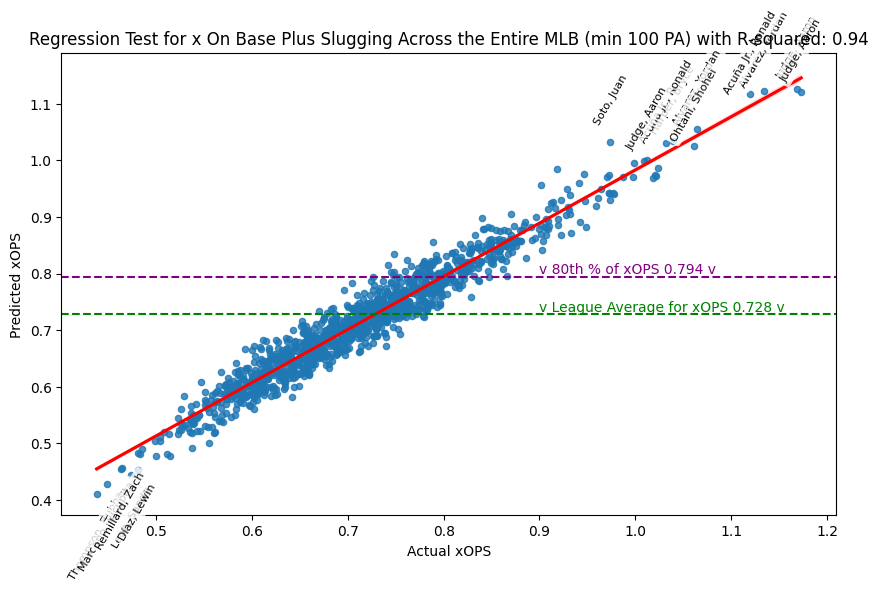

In [11]:
# Regression Test on xOPS
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
M = all_data[['year', 'player_label', 'est_woba']]
n = all_data['est_ops']

# Train a linear regression model
model = LinearRegression()
model.fit(M, n)

# Add a new column for predicted est_ops using feature of xWOBA
all_data['predicted_est_ops'] = model.predict(M)

# Evaluate the model 
mse = mean_squared_error(n, all_data['predicted_est_ops'])
print(f'Mean Squared Error for xOPS: {mse}')

top_players = all_data.nlargest(10, 'predicted_est_ops')
bottom_players = all_data.nsmallest(5, 'predicted_est_ops')

plt.figure(figsize=(10, 6))
sns.regplot(x='est_ops', y='predicted_est_ops', data=all_data, scatter_kws={'s': 20},
            line_kws={'color': 'red'})

league_average_xops = all_data[all_data['year'] == 2023]['est_ops'].mean()
plt.axhline(y=league_average_xops, color='green', linestyle='--', label='League Average xOPS')
percentile_80 = np.percentile(all_data['predicted_est_ops'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of xOPS')

# Calculate and display R-squared
r_squared = r2_score(n, all_data['predicted_est_ops'])
plt.title(
    f'Regression Test for x On Base Plus Slugging Across the Entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual xOPS')
plt.ylabel('Predicted xOPS')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['est_ops'], player['predicted_est_ops']),
                 textcoords="offset points", xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['est_ops'], player['predicted_est_ops']),
                 textcoords="offset points", xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(0.900, percentile_80, f'v 80th % of xOPS {percentile_80:.3f} v', color='purple', ha='left', va='bottom',
        fontsize=10)
plt.text(0.900, league_average_xops, f'v League Average for xOPS {league_average_xops:.3f} v',
        color='green', ha='left', va='bottom', fontsize=10)

plt.show()

Mean Squared Error for xISO: 0.0002975107302930588


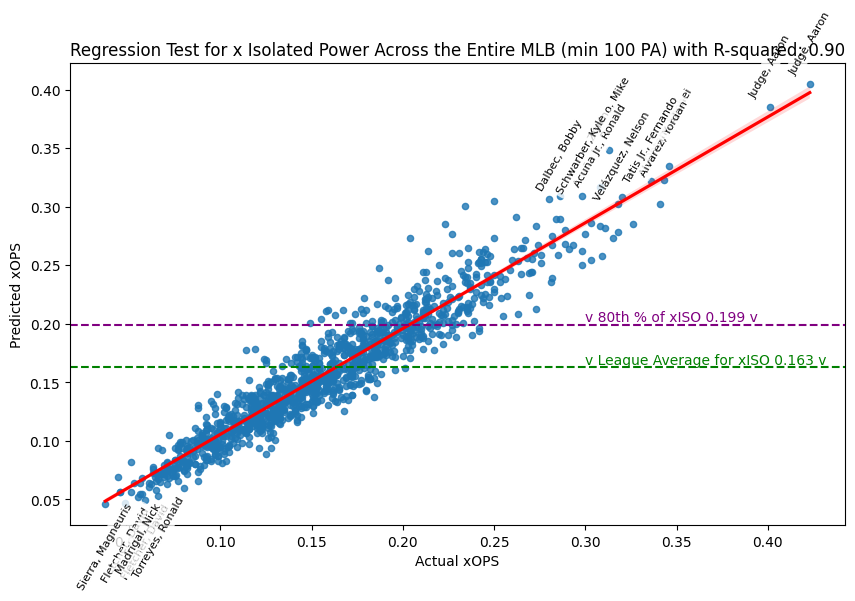

In [12]:
# Regression Test on xISO
label_encoder = LabelEncoder()
all_data['player_label'] = label_encoder.fit_transform(all_data['player_name'])

# Prepare the data
O = all_data[['year', 'player_label', 'avg_hit_speed', 'brl_percent', 'avg_hit_angle']]
p = all_data['est_iso']

# Train a linear regression model
model = LinearRegression()
model.fit(O, p)

# Add a new column for predicted est_iso using features of Avg Hit Speed, barrels percentage, and Avg Hit Angle
all_data['predicted_est_iso'] = model.predict(O)

# Evaluate the model 
mse = mean_squared_error(p, all_data['predicted_est_iso'])
print(f'Mean Squared Error for xISO: {mse}')

top_players = all_data.nlargest(10, 'predicted_est_iso')
bottom_players = all_data.nsmallest(5, 'predicted_est_iso')

plt.figure(figsize=(10, 6))
sns.regplot(x='est_iso', y='predicted_est_iso', data=all_data, scatter_kws={'s': 20},
            line_kws={'color': 'red'})

league_average_xiso = all_data[all_data['year'] == 2023]['est_iso'].mean()
plt.axhline(y=league_average_xiso, color='green', linestyle='--', label='League Average xISO')
percentile_80 = np.percentile(all_data['predicted_est_iso'], 80)
plt.axhline(y=percentile_80, color='purple', linestyle='--', label='80th Percentile of xISO')

# Calculate and display R-squared
r_squared = r2_score(p, all_data['predicted_est_iso'])
plt.title(
    f'Regression Test for x Isolated Power Across the Entire MLB (min 100 PA) with R-squared: {r_squared:.2f}')
plt.xlabel('Actual xOPS')
plt.ylabel('Predicted xOPS')

# Annotate the top players
for i, player in top_players.iterrows():
    plt.annotate(player['player_name'], (player['est_iso'], player['predicted_est_iso']),
                 textcoords="offset points", xytext=(0, 30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

# Annotate the bottom players
for i, player in bottom_players.iterrows():
    plt.annotate(player['player_name'], (player['est_iso'], player['predicted_est_iso']),
                 textcoords="offset points", xytext=(0, -30), ha='center', va='center', fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8), rotation=60)

plt.text(0.300, percentile_80, f'v 80th % of xISO {percentile_80:.3f} v', color='purple', ha='left', va='bottom',
        fontsize=10)
plt.text(0.300, league_average_xiso, f'v League Average for xISO {league_average_xiso:.3f} v',
        color='green', ha='left', va='bottom', fontsize=10)

plt.show()

In [13]:
fielding_data = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\fielding_run_value_new.csv', encoding='utf-8')
data_plus_fielding = pd.merge(all_data, fielding_data, on='player_id')
data_plus_fielding.drop(['player_name_y'], axis=1, inplace=True)
data_plus_fielding.drop(['year_y'], axis=1, inplace=True)
data_plus_fielding = data_plus_fielding.rename(columns={'player_name_x': 'player_name'})
data_plus_fielding = data_plus_fielding.rename(columns={'year_x': 'year'})
data_plus_fielding = data_plus_fielding[
    ['player_name', 'team'] + [col for col in data_plus_fielding.columns if col not in ['player_name', 'team']]]

extra_data = pd.read_csv(r'C:\Users\jsric\OneDrive\Documents\2023extrastats.csv', encoding='utf-8')

def assign_league(team):
    american_league_teams = ['Royals', 'Tigers', 'Twins', 'White Sox', 'Guardians', 'Astros', 'Rangers', 'Athletics', 'Angels', 'Mariners',
                            'Yankees', 'Red Sox', 'Orioles', 'Blue Jays', 'Rays']
    if team in american_league_teams:
        return 'American League'
    else:
        return 'National League'

# Apply the function to create the new "League" column
data_plus_fielding['League'] = data_plus_fielding['team'].apply(assign_league)

# print(data_plus_fielding.to_string())

In [14]:
# Anomaly Detection
# Anomaly Detection on run value to observe some of the outliers of the field
data_plus_fielding['z_score'] = zscore(data_plus_fielding['run_value'])
# Define a threshold for anomaly detection (e.g., 3 standard deviations)
threshold = 3
# Identify anomalies
anomalies = data_plus_fielding[abs(data_plus_fielding['z_score']) > threshold]
# Print or analyze the anomalies
anomalies_unique_run_value = anomalies[['player_name', 'team', 'run_value', 'outs', 'z_score']].drop_duplicates(
    subset=['player_name'])
# Print the unique anomalies
print("Anomaly Players in terms of Run Value that either dramatically hurt their teams chances or helped them:")
print(anomalies_unique_run_value)
print("\n" + "=" * 40 + "\n")  # Add a separator line

Anomaly Players in terms of Run Value that either dramatically hurt their teams chances or helped them:
           player_name       team  run_value  outs   z_score
18     Schwarber, Kyle   Phillies -19.858240  2617 -3.995655
127    Swanson, Dansby       Cubs  14.924753  3838  3.027588
256      Ruiz, Keibert  Nationals -22.997106  3043 -4.629442
457     Doyle, Brenton    Rockies  20.392364  3071  4.131586
518  Maldonado, Martín  White Sox -15.690210  3020 -3.154063
617    Bailey, Patrick     Giants  17.564032  2297  3.560501
855     Hedges, Austin  Guardians  14.888269  1701  3.020221




In [15]:
# Anomaly Detection on xWOBA to observe some of the outliers of the field
data_plus_fielding['z_score'] = zscore(data_plus_fielding['predicted_est_woba(advanced)'])
# Define a threshold for anomaly detection
threshold = 3
# Identify anomalies
anomalies = data_plus_fielding[abs(data_plus_fielding['z_score']) > threshold]
# Print or analyze the anomalies
anomalies_unique_xWoba = anomalies[
    ['player_name', 'team', 'predicted_est_woba(advanced)', 'ba', 'brl_percent']].drop_duplicates(
    subset=['player_name'])
# Print the unique anomalies
print("Anomaly Players in terms of xWOBA for 2024 exceed the norm: ")
print(anomalies_unique_xWoba.to_string())
print("\n" + "=" * 40 + "\n")  # Add a separator line

Anomaly Players in terms of xWOBA for 2024 exceed the norm: 
           player_name      team  predicted_est_woba(advanced)     ba  brl_percent
3    Acuña Jr., Ronald    Braves                      0.452660  0.337         15.3
201     Ohtani, Shohei   Dodgers                      0.430697  0.304         19.6
280      Harper, Bryce  Phillies                      0.420051  0.309         18.1
294      Seager, Corey   Rangers                      0.422083  0.327         15.2
362    Alvarez, Yordan    Astros                      0.426141  0.293         18.0
419       Judge, Aaron   Yankees                      0.464415  0.267         27.5




In [16]:
def generate_team_plots(team_name):
    # Filter data for the specified team
    filtered_data = data_plus_fielding[(data_plus_fielding['team'] == team_name) & (data_plus_fielding['year'] == 2023)]

    # Merge with extra_data
    team_df = pd.merge(filtered_data, extra_data, on=['player_id', 'year'], how='inner')

    # Rename columns
    team_df.rename(columns={'player_name_x': 'player_name', 'team_x': 'team'}, inplace=True)

    # Drop unnecessary columns
    team_df.drop(['player_name_y', 'team_y'], axis=1, inplace=True)

    # Display data frame
    print(f"{team_name} Data Frame (min 100 Plate Appearances):")
    styled_data = (team_df.style)
    display(styled_data)
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    ######################################################################################################################
    # Get the top 5 players in terms of run_value
    top10_run_value = team_df[team_df['run_value'] >= 0].sort_values(by='run_value', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players with Positive Run Value:")
    print(top10_run_value[['player_name', 'run_value']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line


    # Get the top 5 players in terms of outs
    top10_outs = team_df.sort_values(by='outs', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of Outs:")
    print(top10_outs[['player_name', 'outs']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    ######################################################################################################################
    # Get the top 5 players in terms of xbatting average
    top10_xbatting_average = team_df.sort_values(by='est_ba', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name}Players in terms of Batting Average:")
    print(top10_xbatting_average[['player_name', 'ba']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of xbatting average for 2024
    top10_x_batting_average_2024 = team_df.sort_values(by='predicted_est_ba', ascending=False).head(10).reset_index(
        drop=True)
    print(f"Top 5 {team_name} Players in terms of x Batting Average:")
    print(top10_x_batting_average_2024[['player_name', 'est_ba']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    ######################################################################################################################
    # Get the top 5 players in terms of predicted_est_woba(advanced)
    top10_est_woba_2024 = team_df.sort_values(by='predicted_est_woba(advanced)', ascending=False).head(10).reset_index(
        drop=True)
    print(f"Top 5 {team_name} Players in terms of Predicted Estimated xWOBA for 2024:")
    print(top10_est_woba_2024[['player_name', 'predicted_est_woba(advanced)']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of xWOBA
    top10_est_woba = team_df.sort_values(by='est_woba', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of xWOBA:")
    print(top10_est_woba[['player_name', 'est_woba']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    ######################################################################################################################
    # Get the top 5 players in terms of xOPS for 2024
    top10_xops_2024 = team_df.sort_values(by='predicted_est_ops', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of 2024 Predicted xOPS:")
    print(top10_xops_2024[['player_name', 'predicted_est_ops']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of xOPS
    top10_xops = team_df.sort_values(by='est_ops', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of xOPS:")
    print(top10_xops[['player_name', 'est_ops']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    #######################################################################################################################
    # Get the top 5 players in terms of xISO for 2024
    top10_xiso_2024 = team_df.sort_values(by='predicted_est_iso', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of 2024 Predicted xISO:")
    print(top10_xiso_2024[['player_name', 'predicted_est_iso']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    
    # Get the top 5 players in terms of xISO
    top10_xiso = team_df.sort_values(by='est_iso', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of xISO:")
    print(top10_xiso[['player_name', 'est_iso']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    #######################################################################################################################
    # Get the top 5 players in terms of xSLG for 2024
    top10_xslg_2024 = team_df.sort_values(by='predicted_est_slg', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of 2024 Predicted xSLG:")
    print(top10_xslg_2024[['player_name', 'predicted_est_slg']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of xSLG
    top10_xslg = team_df.sort_values(by='est_slg', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of xSLG:")
    print(top10_xslg[['player_name', 'est_slg']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    ######################################################################################################################
    # Get the top 5 players in terms of Barrels per PA for 2024
    top10_brl_pa_2024 = team_df.sort_values(by='predicted_brl_pa', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of 2024 Predicted Barrels per Plate Appearance:")
    print(top10_brl_pa_2024[['player_name', 'predicted_brl_pa']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of Barrels per PA
    top10_brl_pa = team_df.sort_values(by='brl_pa', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of Barrels per Plate Appearance:")
    print(top10_brl_pa[['player_name', 'brl_pa']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    #####################################################################################################################
    # Get the top 5 players in terms of Average Hit Angle for 2024
    top10_avg_hit_angle_2024 = team_df.sort_values(by='predicted_avg_hit_angle', ascending=False).head(10).reset_index(
        drop=True)
    print(f"Top 5 {team_name} Players in terms of 2024 Predicted Average Hit Angle:")
    print(top10_avg_hit_angle_2024[['player_name', 'predicted_avg_hit_angle']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of Average Hit Angle
    top10_avg_hit_angle = team_df.sort_values(by='avg_hit_angle', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of Average Hit Angle:")
    print(top10_avg_hit_angle[['player_name', 'avg_hit_angle']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    #####################################################################################################################
    # Get the top 5 players in terms of Average Hit Speed for 2024
    top10_avg_hit_speed_2024 = team_df.sort_values(by='predicted_avg_hit_speed', ascending=False).head(10).reset_index(
        drop=True)
    print(f"Top 5 {team_name} Players in terms of 2024 Predicted Average Hit Speed:")
    print(top10_avg_hit_speed_2024[['player_name', 'predicted_avg_hit_speed']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of Average Hit Speed
    top10_avg_hit_speed = team_df.sort_values(by='avg_hit_speed', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of Average Hit Speed:")
    print(top10_avg_hit_speed[['player_name', 'avg_hit_speed']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    #####################################################################################################################
    # Get the top 5 players in terms of Average Hit Distance for 2024
    top10_avg_distance_2024 = team_df.sort_values(by='predicted_avg_distance', ascending=False).head(10).reset_index(
        drop=True)
    print(f"Top 5 {team_name} Players in terms of 2024 Predicted Average Hit Distance:")
    print(top10_avg_distance_2024[['player_name', 'predicted_avg_distance']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line

    # Get the top 5 players in terms of Average Hit Distance
    top10_avg_distance = team_df.sort_values(by='avg_distance', ascending=False).head(10).reset_index(drop=True)
    print(f"Top 5 {team_name} Players in terms of Average Hit Distance:")
    print(top10_avg_distance[['player_name', 'avg_distance']])
    print("\n" + "=" * 40 + "\n")  # Add a separator line
    #####################################################################################################################

    ####################################################################################################################
    # xWoba Bar Charts
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the same color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of predicted_est_woba(advanced) for 2024
    axs[0].bar(top10_est_woba_2024['player_name'], top10_est_woba_2024['predicted_est_woba(advanced)'], color=bar_color)
    axs[0].axhline(y=league_average_xwoba, color='red', linestyle='--', label='League Average xWOBA')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted Estimated xWOBA')
    axs[0].set_ylabel('2024 Predicted Estimated xWOBA')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_est_woba_2024['predicted_est_woba(advanced)']):
        axs[0].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of xWOBA
    axs[1].bar(top10_est_woba['player_name'], top10_est_woba['est_woba'], color=bar_color)
    axs[1].axhline(y=league_average_xwoba, color='red', linestyle='--', label='League Average xWOBA')
    axs[1].set_title(f'Top 5 {team_name} Players - xWOBA')
    axs[1].set_ylabel('xWOBA')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_est_woba['est_woba']):
        axs[1].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    # Show the plot
    plt.show()
    ######################################################################################################################
    # Bar Charts for xOPS
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of xOPS for 2024
    axs[0].bar(top10_xops_2024['player_name'], top10_xops_2024['predicted_est_ops'], color=bar_color)
    axs[0].axhline(y=league_average_xops, color='red', linestyle='--', label='League Average xOPS')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted xOPS')
    axs[0].set_ylabel('2024 xOPS')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_xops_2024['predicted_est_ops']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of xOPS
    axs[1].bar(top10_xops['player_name'], top10_xops['est_ops'], color=bar_color)
    axs[1].axhline(y=league_average_xops, color='red', linestyle='--', label='League Average xOPS')
    axs[1].set_title(f'Top 5 {team_name} Players - xOPS')
    axs[1].set_ylabel('xOPS')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_xops['est_ops']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    ######################################################################################################################
    # Bar Charts for xISO
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of xISO for 2024
    axs[0].bar(top10_xiso_2024['player_name'], top10_xiso_2024['predicted_est_iso'], color=bar_color)
    axs[0].axhline(y=league_average_xiso, color='red', linestyle='--', label='League Average xISO')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted xISO')
    axs[0].set_ylabel('2024 xISO')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_xiso_2024['predicted_est_iso']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)
    
    # Bar chart for top 5 players in terms of xISO
    axs[1].bar(top10_xiso['player_name'], top10_xiso['est_iso'], color=bar_color)
    axs[1].axhline(y=league_average_xiso, color='red', linestyle='--', label='League Average xISO')
    axs[1].set_title(f'Top 5 {team_name} Players - xISO')
    axs[1].set_ylabel('xISO')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_xiso['est_iso']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    ######################################################################################################################
    # xBatting Average Bar Charts
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of xbatting average for 2024
    axs[0].bar(top10_x_batting_average_2024['player_name'], top10_x_batting_average_2024['predicted_est_ba'], color=bar_color)
    axs[0].axhline(y=league_average_xba, color='red', linestyle='--', label='League Average xBA')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted xBatting Average')
    axs[0].set_ylabel('2024 xBatting Average')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_x_batting_average_2024['predicted_est_ba']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of x batting average
    axs[1].bar(top10_xbatting_average['player_name'], top10_xbatting_average['est_ba'], color=bar_color)
    axs[1].axhline(y=league_average_xba, color='red', linestyle='--', label='League Average xBA')
    axs[1].set_title(f'Top 5 {team_name} Players - xBatting Average')
    axs[1].set_ylabel('xBatting Average')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_x_batting_average_2024['est_ba']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    ######################################################################################################################
    # Bar charts for xSLG
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of xSLG for 2024
    axs[0].bar(top10_xslg_2024['player_name'], top10_xslg_2024['predicted_est_slg'], color=bar_color)
    axs[0].axhline(y=league_average_xslg, color='red', linestyle='--', label='League Average xSLG')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted xSLG')
    axs[0].set_ylabel('2024 xSLG')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_xslg_2024['predicted_est_slg']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of xSLG
    axs[1].bar(top10_xslg['player_name'], top10_xslg['est_slg'], color=bar_color)
    axs[1].axhline(y=league_average_xslg, color='red', linestyle='--', label='League Average xSLG')
    axs[1].set_title(f'Top 5 {team_name} Players - xSLG')
    axs[1].set_ylabel('xSLG')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_xslg['est_slg']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    ######################################################################################################################
    # Bar Charts for Barrels per PA
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of Brl per PA for 2024
    axs[0].bar(top10_brl_pa_2024['player_name'], top10_brl_pa_2024['predicted_brl_pa'], color=bar_color)
    axs[0].axhline(y=league_average_brl_pa, color='red', linestyle='--', label='League Average Barrels per PA')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted Barrels per Plate Appearance')
    axs[0].set_ylabel('2024 Barrels per Appearance')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_brl_pa_2024['predicted_brl_pa']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of Brl per PA
    axs[1].bar(top10_brl_pa['player_name'], top10_brl_pa['brl_pa'], color=bar_color)
    axs[1].axhline(y=league_average_brl_pa, color='red', linestyle='--', label='League Average Barrels per PA')
    axs[1].set_title(f'Top 5 {team_name} Players - Barrels per Plate Appearance')
    axs[1].set_ylabel('Barrels per Plate Appearance')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_brl_pa['brl_pa']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    ######################################################################################################################
    # Bar Charts for Average Hit Angle
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of Avg Hit Angle for 2024
    axs[0].bar(top10_avg_hit_angle_2024['player_name'], top10_avg_hit_angle_2024['predicted_avg_hit_angle'], color=bar_color)
    axs[0].axhline(y=league_average_avg_hit_angle, color='red', linestyle='--', label='League Average Average Hit Angle')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted Average Hit Angle')
    axs[0].set_ylabel('2024 Average Hit Angle')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_avg_hit_angle_2024['predicted_avg_hit_angle']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of Average Hit Angle
    axs[1].bar(top10_avg_hit_angle['player_name'], top10_avg_hit_angle['avg_hit_angle'], color=bar_color)
    axs[1].axhline(y=league_average_avg_hit_angle, color='red', linestyle='--', label='League Average Average Hit Angle')
    axs[1].set_title(f'Top 5 {team_name} Players - Average Hit Angle')
    axs[1].set_ylabel('Average Hit Angle')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_avg_hit_angle['avg_hit_angle']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    ######################################################################################################################
    # Bar Charts for Average Hit Speed
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of Avg Hit Speed for 2024
    axs[0].bar(top10_avg_hit_speed_2024['player_name'], top10_avg_hit_speed_2024['predicted_avg_hit_speed'], color=bar_color)
    axs[0].axhline(y=league_average_avg_hit_speed, color='red', linestyle='--', label='League Average Average Hit Speed')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted Average Hit Speed')
    axs[0].set_ylabel('2024 Average Hit Speed')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_avg_hit_speed_2024['predicted_avg_hit_speed']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of Average Hit Speed
    axs[1].bar(top10_avg_hit_speed['player_name'], top10_avg_hit_speed['avg_hit_speed'], color=bar_color)
    axs[1].axhline(y=league_average_avg_hit_speed, color='red', linestyle='--', label='League Average Average Hit Speed')
    axs[1].set_title(f'Top 5 {team_name} Players - Average Hit Speed')
    axs[1].set_ylabel('Average Hit Speed')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_avg_hit_speed['avg_hit_speed']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    #####################################################################################################################
    # Bar Charts for Average Hit Distance
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of Avg Hit Distance for 2024
    axs[0].bar(top10_avg_distance_2024['player_name'], top10_avg_distance_2024['predicted_avg_distance'], color=bar_color)
    axs[0].axhline(y=league_average_avg_distance, color='red', linestyle='--', label='League Average Average Hit Distance')
    axs[0].set_title(f'Top 5 {team_name} Players - 2024 Predicted Average Hit Distance')
    axs[0].set_ylabel('2024 Average Hit Distance')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_avg_distance_2024['predicted_avg_distance']):
        axs[0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of Average Hit Angle
    axs[1].bar(top10_avg_distance['player_name'], top10_avg_distance['avg_distance'], color=bar_color)
    axs[1].axhline(y=league_average_avg_distance, color='red', linestyle='--', label='League Average Average Hit Distance')
    axs[1].set_title(f'Top 5 {team_name} Players - Average Hit Distance')
    axs[1].set_ylabel('Average Hit Distance')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_avg_distance['avg_distance']):
        axs[1].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    axs[0].legend()
    axs[1].legend()
    
    # Show the plot
    plt.show()
    #####################################################################################################################

    #####################################################################################################################
    # Run Value and Outs Bar Charts
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Set the color for both bar charts
    bar_color = 'steelblue'

    # Bar chart for top 5 players in terms of run value
    axs[0].bar(top10_run_value['player_name'], top10_run_value['run_value'], color=bar_color)
    axs[0].set_title(f'Top 5 {team_name} Players - Run Value')
    axs[0].set_ylabel('Run Value')
    axs[0].tick_params(axis='x', rotation=45, labelsize=8)
    axs[0].set_xlabel('Player Name')
    axs[0].grid(axis='y')

    # Add value annotations at the top of each bar for the first subplot
    for i, v in enumerate(top10_run_value['run_value']):
        axs[0].text(i, v + 0.1, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Bar chart for top 5 players in terms of outs
    axs[1].bar(top10_outs['player_name'], top10_outs['outs'], color=bar_color)
    axs[1].set_title(f'Top 5 {team_name} Players - Outs')
    axs[1].set_ylabel('Outs')
    axs[1].tick_params(axis='x', rotation=45, labelsize=8)
    axs[1].set_xlabel('Player Name')
    axs[1].grid(axis='y')

    # Add value annotations at the top of each bar for the second subplot
    for i, v in enumerate(top10_outs['outs']):
        axs[1].text(i, v + 0.1, str(round(v, 3)), ha='center', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    ######################################################################################################################
    # Scatterplot for Barrel per PA and avg hit speed with xSLG as value
    # Set the size of the points based on est_slg

    league_average_slg = 0.413
    point_size = 100  # Set a default size for all points

    # Create a scatter plot with color representing est_slg values
    scatter = plt.scatter(team_df['avg_hit_speed'], team_df['brl_pa'], s=point_size, alpha=0.5, c=team_df['est_slg'],
                          cmap='Blues', vmin=team_df['est_slg'].min(), vmax=team_df['est_slg'].max())

    # Set labels and title
    plt.xlabel('Average Hit Speed')
    plt.ylabel('Barrel per Plate Appearance')
    plt.title(f'Scatter Plot of Average Hit Speed vs. Barrel per Plate Appearance for the {team_name}')

    # Add a colorbar to show est_slg values
    cbar = plt.colorbar(scatter)
    cbar.set_label('est_slg')

    # Add player_name and est_slg annotations
    for i, row in team_df.iterrows():
        plt.annotate(f"{row['player_name']}\n{row['est_slg']:.3f}", (row['avg_hit_speed'], row['brl_pa']), fontsize=8,
                     ha='center', va='bottom')

    # Show the plot
    plt.show()
    ######################################################################################################################
    # Scatter PLot for Damage
    point_size = 100  # Set a default size for all points
    # Create a scatter plot with color representing est_slg values
    scatter = plt.scatter(team_df['on_base_plus_slg'], team_df['xiso'], s=point_size, alpha=0.5,
                          c=team_df['player_age'],
                          cmap='Blues', vmin=team_df['player_age'].min(), vmax=team_df['player_age'].max())

    # Set labels and title
    plt.xlabel('On Base Plus Slug')
    plt.ylabel('x Isolated Power')
    plt.title(f'Scatter Plot of OPS vs. xISO with Players Age for the {team_name}')

    cbar = plt.colorbar(scatter)
    cbar.set_label('player_age')

    for i, row in team_df.iterrows():
        age_label = f"$\\bf{{{row['player_name']}}}$\n$\\bf{{{int(row['player_age'])}}}$"  # Bold text using LaTeX-like syntax
        plt.annotate(age_label, (row['on_base_plus_slg'], row['xiso']), fontsize=8, ha='center', va='bottom')

    plt.show()
    ######################################################################################################################
    print(f'Points Breakdown for the {team_name}.')
    # Points Function
    player_points = {}

    def assign_points(top10_df):
        for idx, row in top10_df.iterrows():
            player_name = row['player_name']
            points = len(top10_df) - idx  # Ensure points are non-negative
            
            if player_name in player_points:
                player_points[player_name] += points
            else:
                player_points[player_name] = points

    # Assign points based on ranking
    assign_points(top10_run_value)
    assign_points(top10_x_batting_average_2024)
    assign_points(top10_xslg_2024)
    assign_points(top10_est_woba_2024)
    assign_points(top10_brl_pa_2024)
    assign_points(top10_avg_hit_angle_2024)
    assign_points(top10_avg_hit_speed_2024)
    assign_points(top10_avg_distance_2024)
    assign_points(top10_xops_2024)
    assign_points(top10_xiso_2024)

    second_player = None  # Initialize outside any block
    third_player = None  # Initialize outside any block

    # Display the total points for each player
    for player, points in sorted(player_points.items(), key=lambda x: x[1], reverse=True):
        print(f"{player}: {points} points")
    if player_points:
        max_player, max_points = max(player_points.items(), key=lambda x: x[1])
        print(f"\nPlayer with the most points: {max_player} with {max_points} points")
        player_points.pop(max_player)  # Remove the player with the most points

        if player_points:
            second_player, second_points = max(player_points.items(), key=lambda x: x[1])
            print(f"Second place: {second_player} with {second_points} points")

            player_points.pop(second_player)  # Remove the second-place player

            if player_points:
                third_player, third_points = max(player_points.items(), key=lambda x: x[1])
                print(f"Third place: {third_player} with {third_points} points")
    else:
        print("\nNo players to evaluate.")
    ######################################################################################################################
    def analyze_player_rankings(max_player, top10_run_value, top10_x_batting_average_2024, top10_xslg_2024,
                                top10_est_woba_2024, top10_brl_pa_2024, top10_avg_hit_angle_2024, top10_avg_hit_speed_2024,
                                top10_avg_distance_2024, top10_xops_2024, top10_xiso_2024):
        categories = {
            'Run Value': top10_run_value,
            'Predicted xBatting Average 2024': top10_x_batting_average_2024,
            'xSLG 2024': top10_xslg_2024,
            'Predicted xWOBA 2024': top10_est_woba_2024,
            'Barrels per PA 2024': top10_brl_pa_2024,
            'Average Hit Angle 2024': top10_avg_hit_angle_2024,
            'Average Hit Speed 2024': top10_avg_hit_speed_2024,
            'Average Distance 2024': top10_avg_distance_2024,
            'Predicted xOPS 2024': top10_xops_2024,
            'Predicted xISO 2024': top10_xiso_2024,
        }
        for category, top10_players in categories.items():
            player_rank = top10_players[top10_players['player_name'] == max_player].index.tolist()
            if player_rank:
                print(f'{max_player} ranked {player_rank[0] + 1} in {category}.')
            else:
                print(f'{max_player} is not in the top 5 for {category}.')

    ###################################################################################################################
    print("\n" + "=" * 40 + "\n")
    print(
        f'For our analysis of the {team_name} we observe a few key results. {max_player} is the our predicted key\n'
        f'contributors for the {team_name} the 2024 MLB season. {max_player} contributes a large value to his team,\n'
        f'scoring high in numerous categories. Specifically {max_player} placed in these categories:')
    analyze_player_rankings(max_player, top10_run_value, top10_x_batting_average_2024, top10_xslg_2024, top10_est_woba_2024,
                            top10_brl_pa_2024, top10_avg_hit_angle_2024, top10_avg_hit_speed_2024, top10_avg_distance_2024,
                            top10_xops_2024, top10_xiso_2024)
    print("\n" + "=" * 40 + "\n")
    print(
        f'{second_player} and {third_player} also scored well in most categories as well. In our analysis we must\n'
        f'keep a few factors in mind when we make our predictions. 1: A few of these players score well in specific\n'
        f'categories because they are platoon players (players who only off pitchers they hit will against commonly\n'
        f'left hitting hitters hitting against right handed pitchers and vise versa) 2: I sampled players with only\n'
        f'100 Plate Appearances. I wanted to analyze a diverse amount of players (Rookies, Injured Players, Platoon\n'
        f'Only Players). 3: Some players have only played one season so its more difficult to analyze historical\n'
        f'data. 4: Some players have had incredible 2021 and 2022 seasons but have since fallen off. Thus, to an \n'
        f'average watcher of the MLB some players may seem unlikely to be the key influence player, however, I used\n'
        f'Linear Regression, historical data, and advanced key metrics to determine the key influencers of 2024.\n'
        f'So this may include some players who have have not performed well in the previous year (i.e. Josh\n'
        f'Donaldson) and some players who have only performed well in the previous year (i.e. Christian E-Strand).\n'
        f'I utilized advanced hitting metrics and Linear Regression to formulate a educated estimation.\n\n'

        f'\033[1m{max_player} is my predicted key top contributor for the {team_name} for the 2024 MLB season.\033[0m')
    print("\n" + "=" * 40 + "\n")

    # Create a podium visualization
    def display_podium(max_player, second_player, third_player):
        print(" -----Awards Podium------- ")
        print(" -------------------------")

        max_len = 15
        second_len = 10
        third_len = 5

        first_player_data = all_data[all_data['player_name'] == max_player]
        second_player_data = all_data[all_data['player_name'] == second_player]
        third_player_data = all_data[all_data['player_name'] == third_player]

        # Extract the predicted_xba for the player
        predicted_first_place_xba = first_player_data['predicted_est_ba'].values[0]
        predicted_second_place_xba = second_player_data['predicted_est_ba'].values[0]
        predicted_third_place_xba = third_player_data['predicted_est_ba'].values[0]
        
        # Extract the predicted_xslg for the player
        predicted_first_place_xslg = first_player_data['predicted_est_slg'].values[0]
        predicted_second_place_xslg = second_player_data['predicted_est_slg'].values[0]
        predicted_third_place_xslg = third_player_data['predicted_est_slg'].values[0]
        
        # Extract the predicted_xwoba for the player
        predicted_first_place_xwoba = first_player_data['predicted_est_woba(advanced)'].values[0]
        predicted_second_place_xwoba = second_player_data['predicted_est_woba(advanced)'].values[0]
        predicted_third_place_xwoba = third_player_data['predicted_est_woba(advanced)'].values[0]
        
        # Print each place with a bar
        print(f""" 2nd: {('=' * second_len) + '|'} {second_player} xBA:{predicted_second_place_xba.round(3)} / xSLG:{predicted_second_place_xslg.round(3)} / xWOBA:{predicted_second_place_xwoba.round(3)}"""
             )
        
        print(f""" 1st: {('=' * max_len) + '|'} {max_player} xBA:{predicted_first_place_xba.round(3)} / xSLG:{predicted_third_place_xslg.round(3)} / xWOBA:{predicted_first_place_xwoba.round(3)}"""
             )
        
        print(f""" 3rd: {('=' * third_len) + '|'} {third_player} xBA:{predicted_third_place_xba.round(3)} / xSLG:{predicted_third_place_xslg.round(3)} / xWOBA:{predicted_third_place_xwoba.round(3)}"""
             )

    display_podium(max_player, second_player, third_player)

Enter a team to analyze:  Twins


Twins Data Frame (min 100 Plate Appearances):




Top 5 Twins Players with Positive Run Value:
          player_name  run_value
0  Taylor, Michael A.   9.007932
1  Vázquez, Christian   4.509189
2         Kepler, Max   4.389517
3       Castro, Willi   2.443991
4        Farmer, Kyle   1.645079
5        Lewis, Royce   0.672301
6     Julien, Edouard   0.064309
7       Buxton, Byron   0.000000


Top 5 Twins Players in terms of Outs:
          player_name  outs
0      Correa, Carlos  3433
1         Kepler, Max  2917
2  Taylor, Michael A.  2881
3       Castro, Willi  2589
4  Vázquez, Christian  2458
5        Farmer, Kyle  2389
6     Solano, Donovan  2379
7       Jeffers, Ryan  1975
8     Kirilloff, Alex  1874
9      Polanco, Jorge  1714


Top 5 TwinsPlayers in terms of Batting Average:
       player_name     ba
0  Solano, Donovan  0.282
1      Kepler, Max  0.260
2     Lewis, Royce  0.309
3  Kirilloff, Alex  0.270
4   Correa, Carlos  0.230
5     Farmer, Kyle  0.256
6   Polanco, Jorge  0.255
7    Miranda, Jose  0.211
8    Castro, Willi  0.25

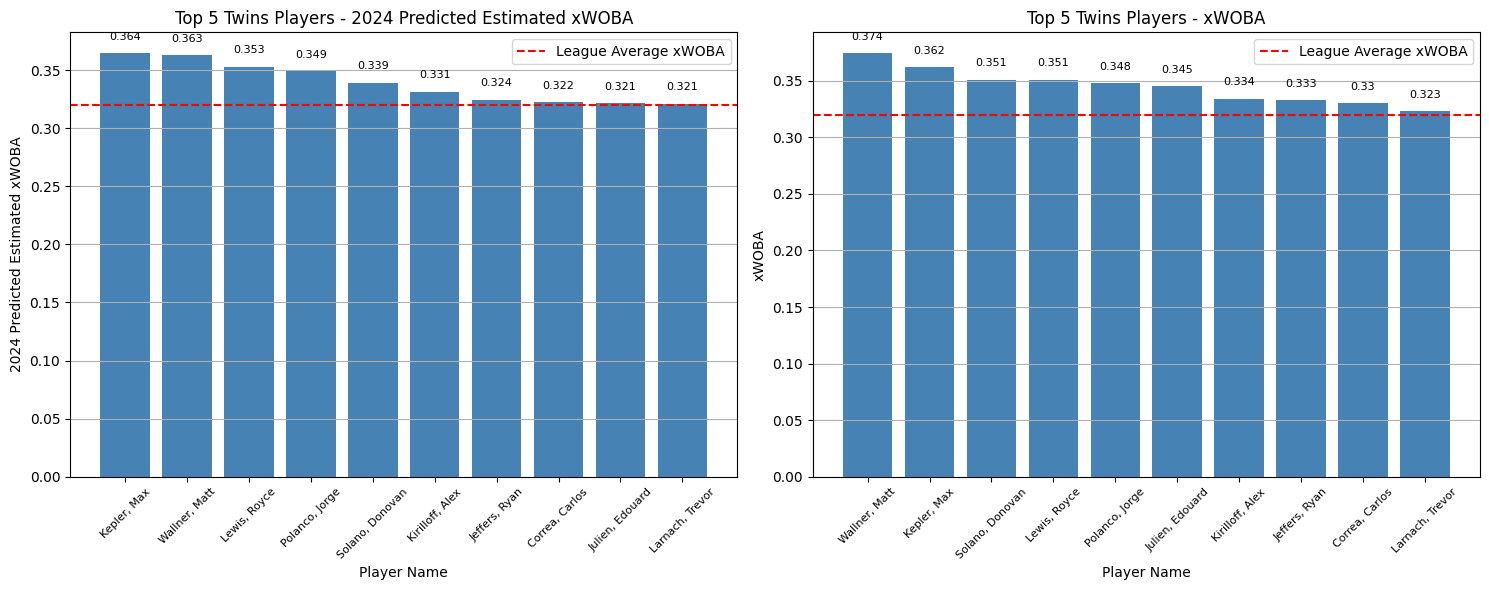

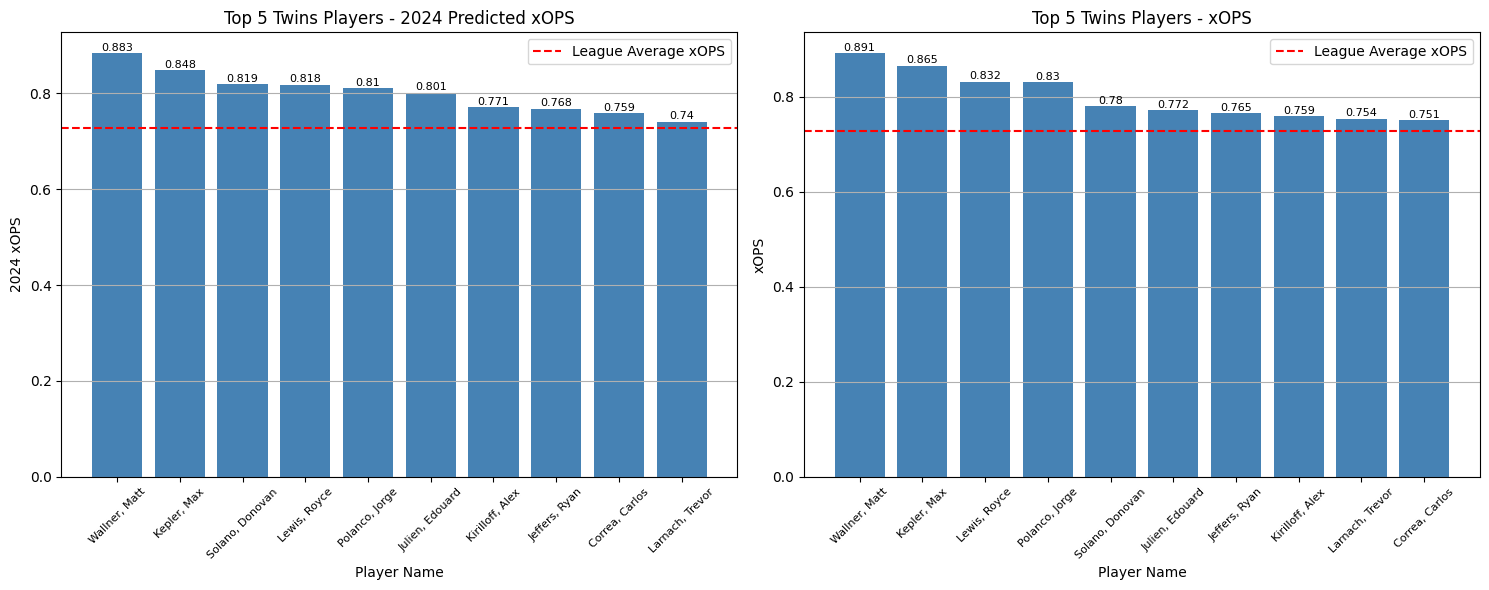

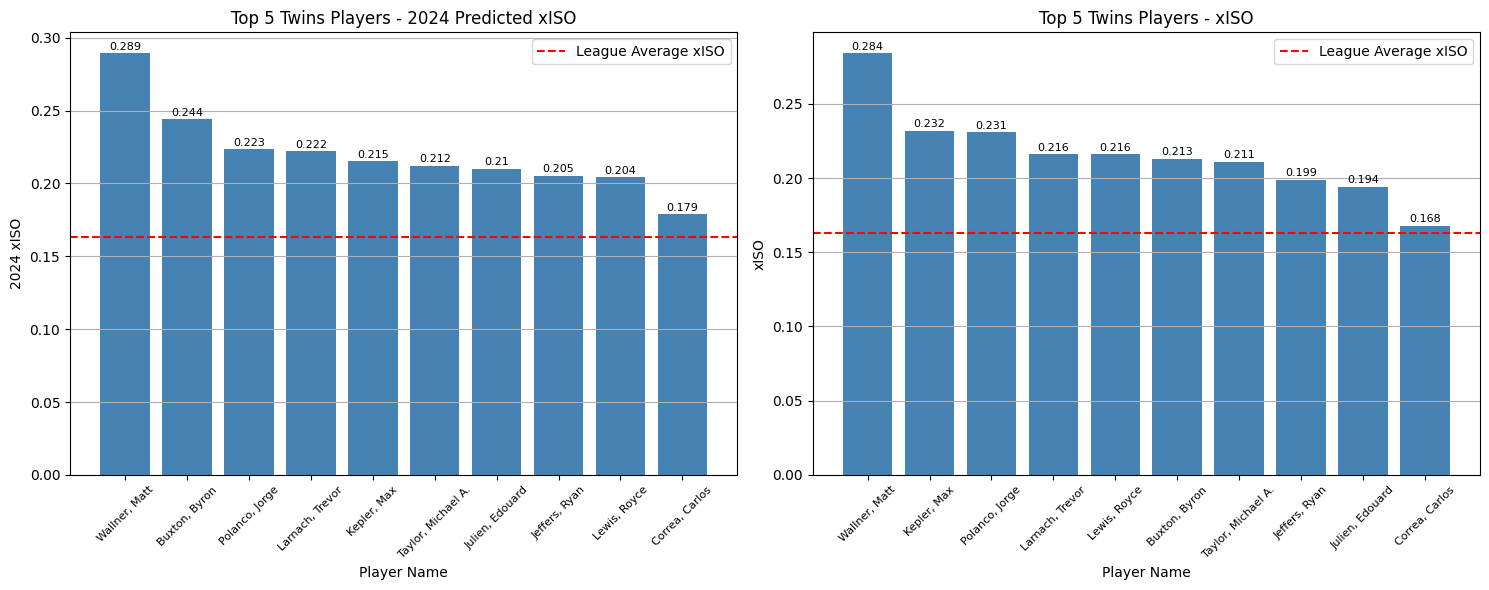

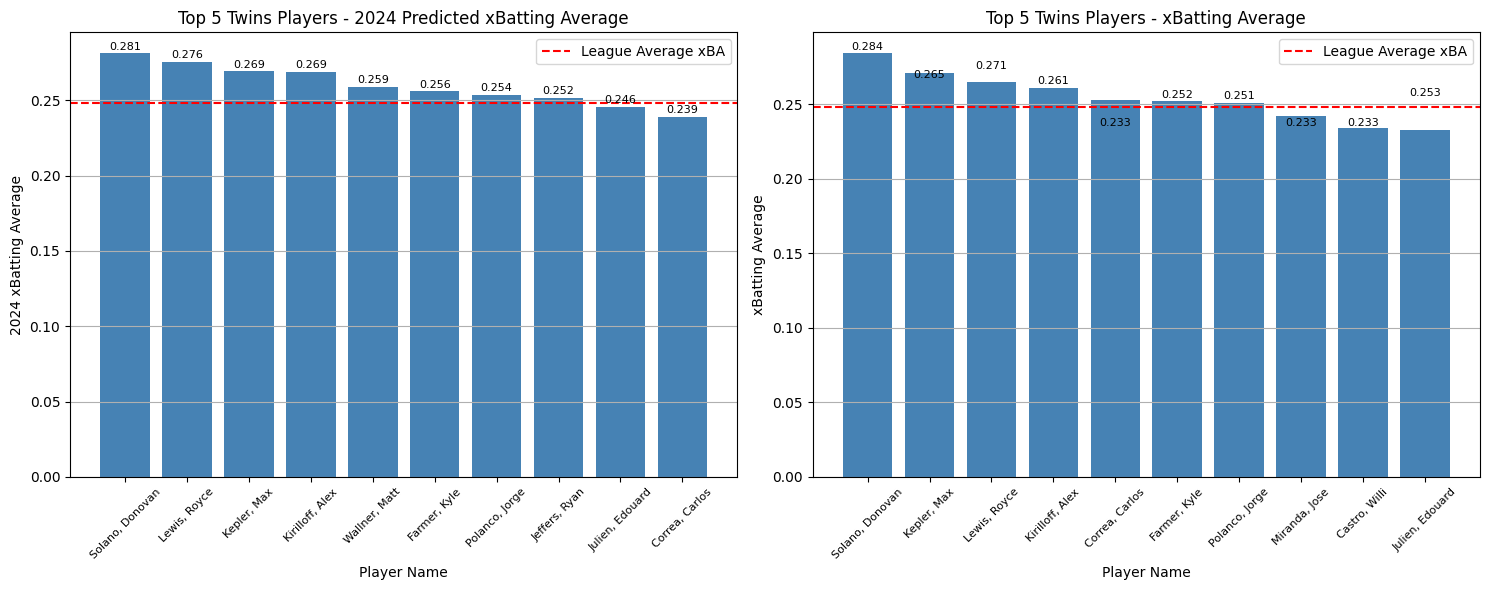

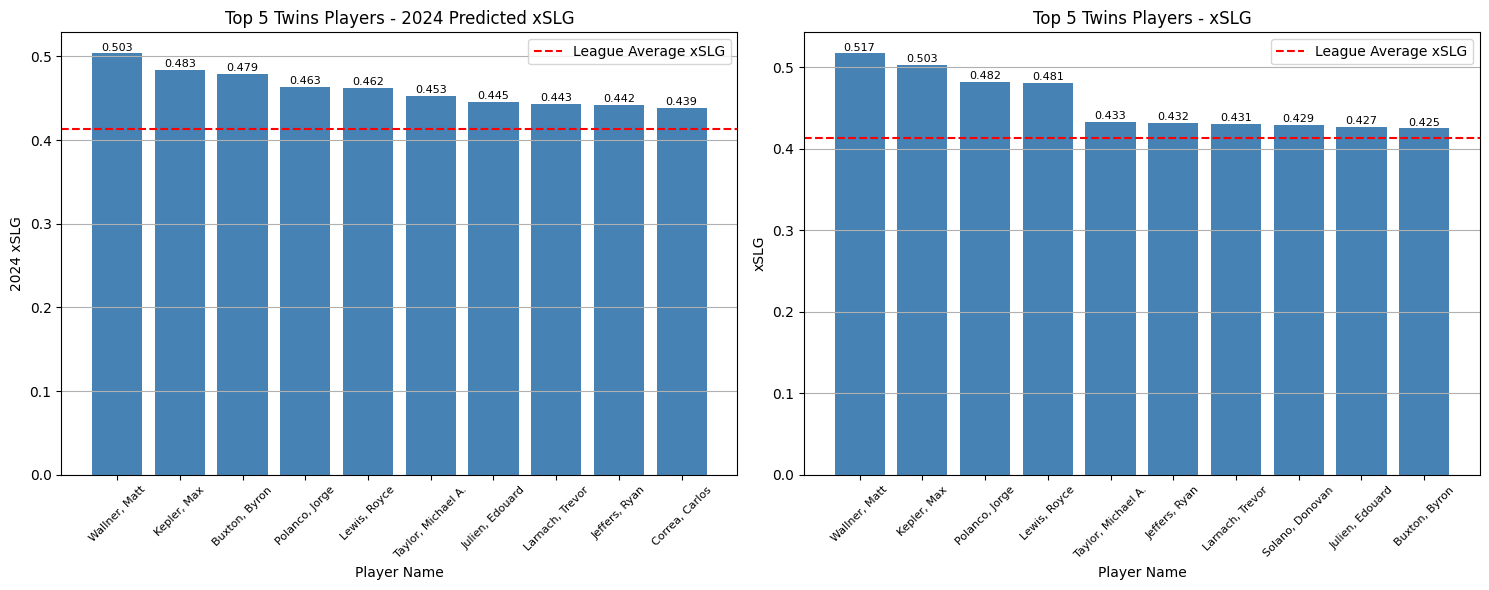

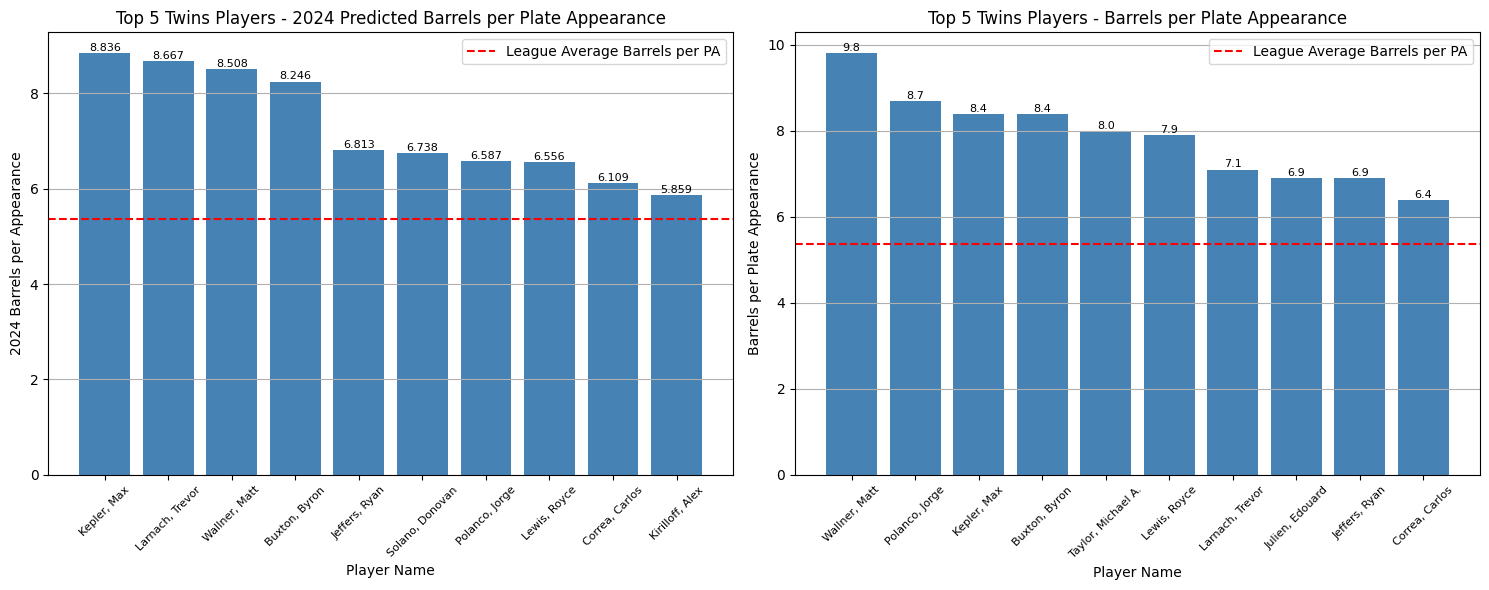

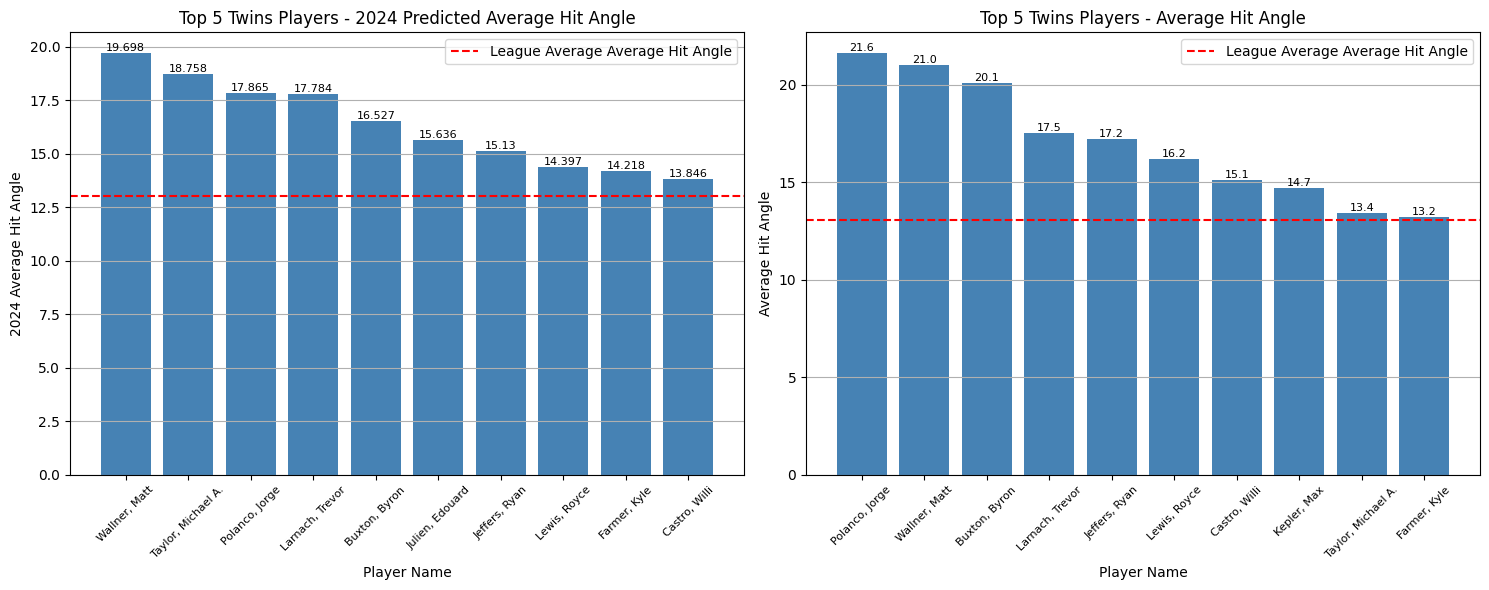

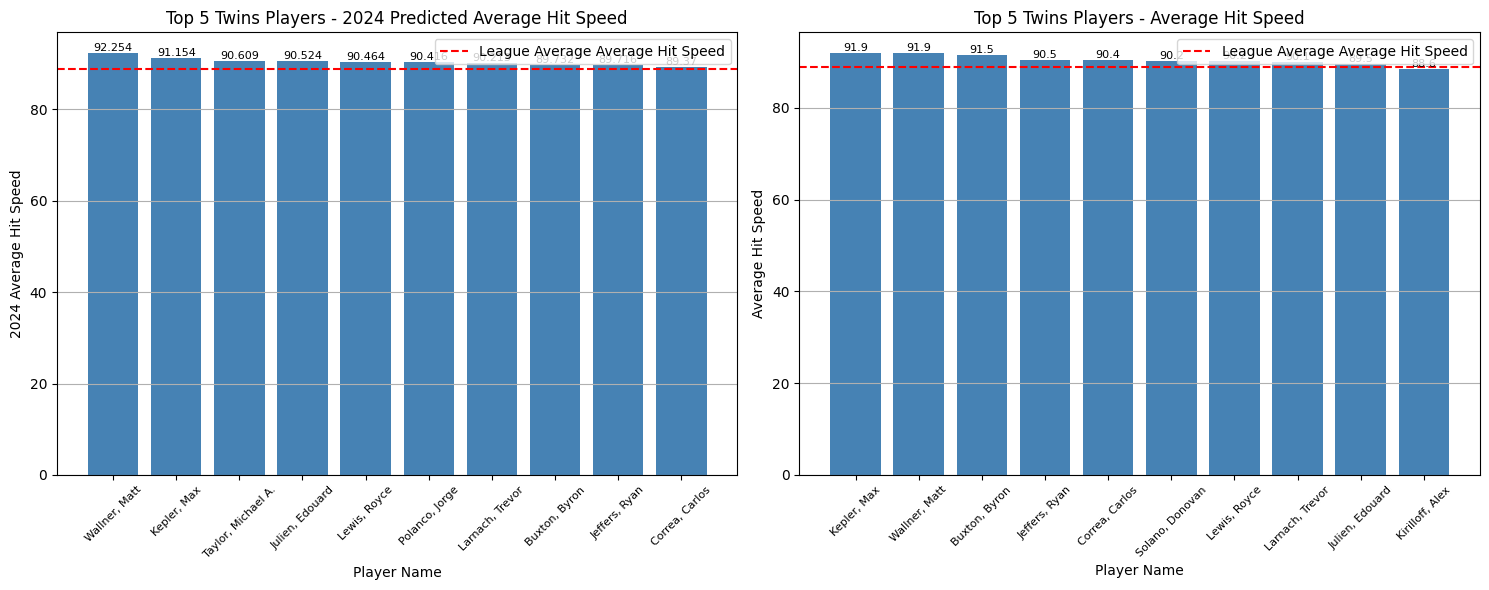

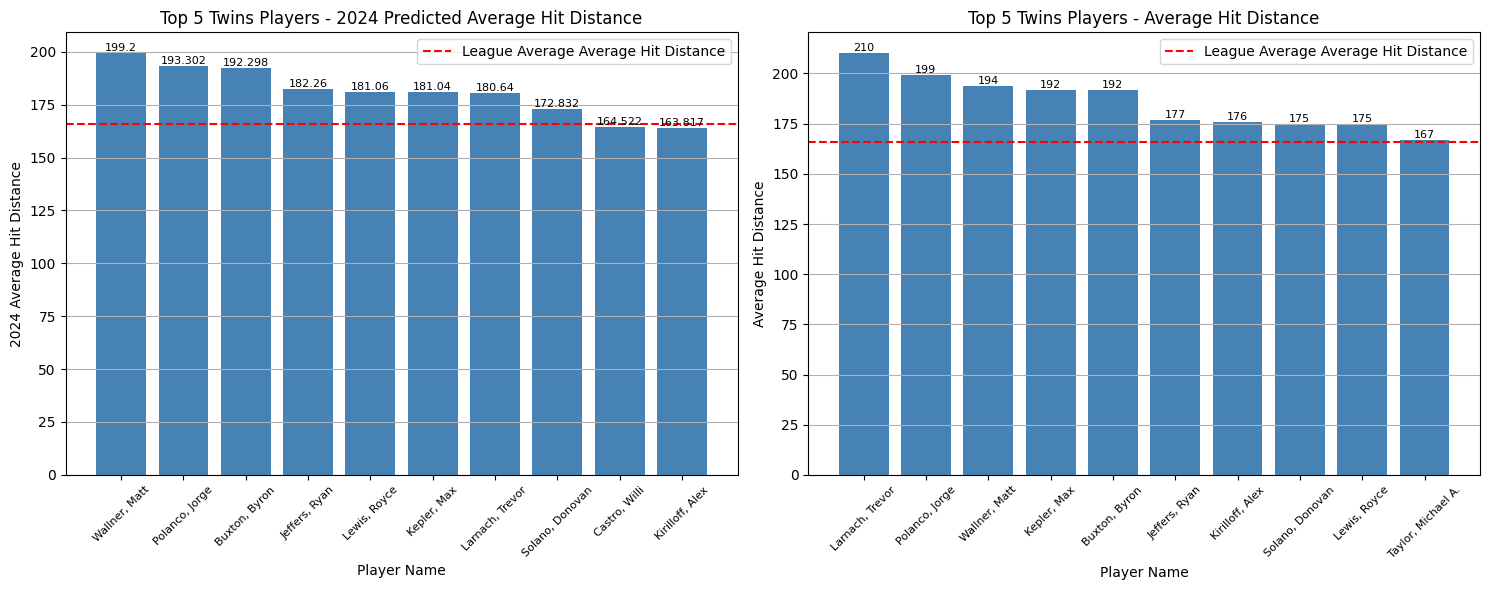

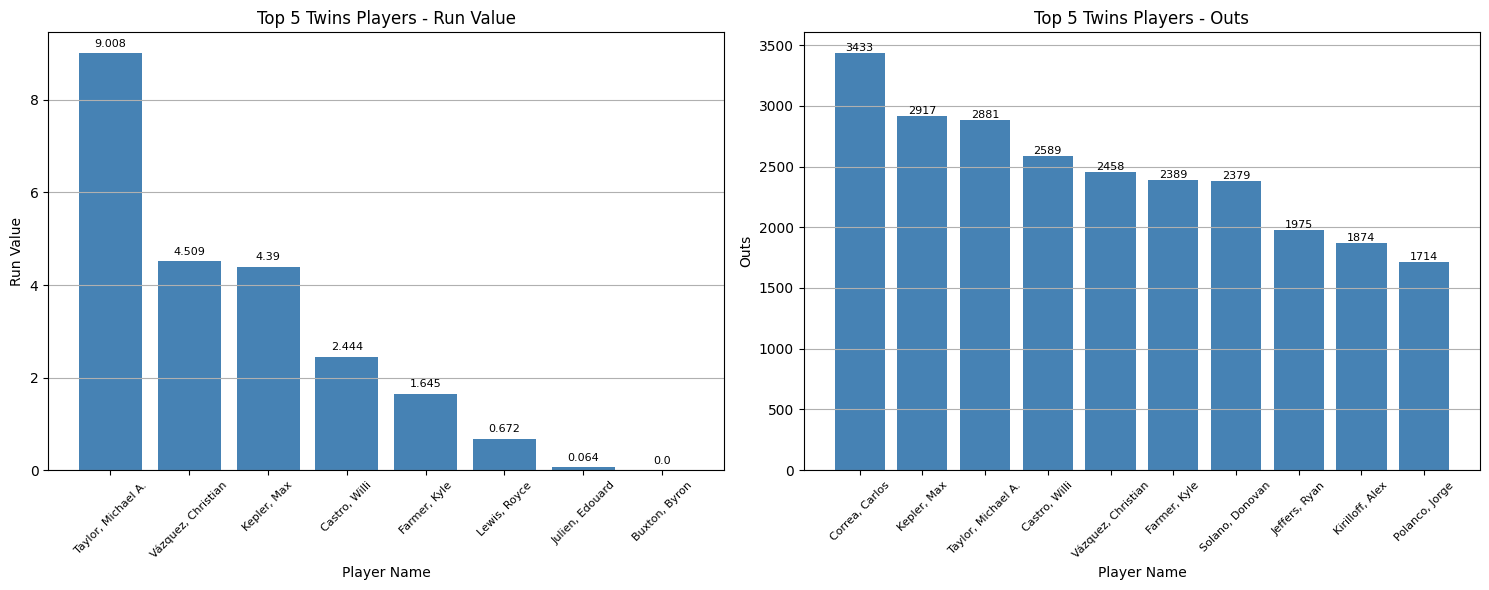

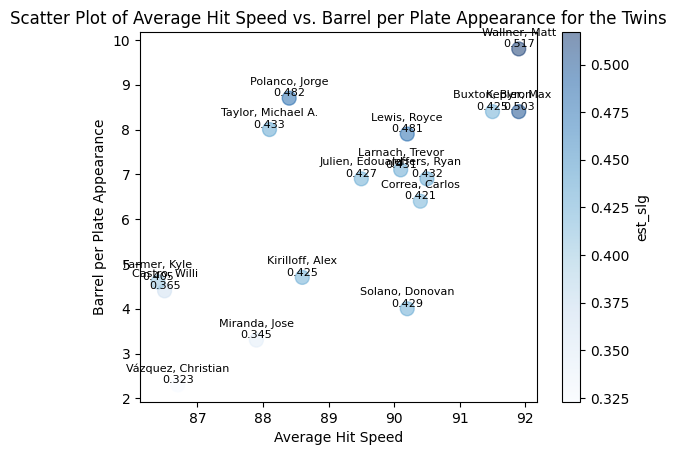

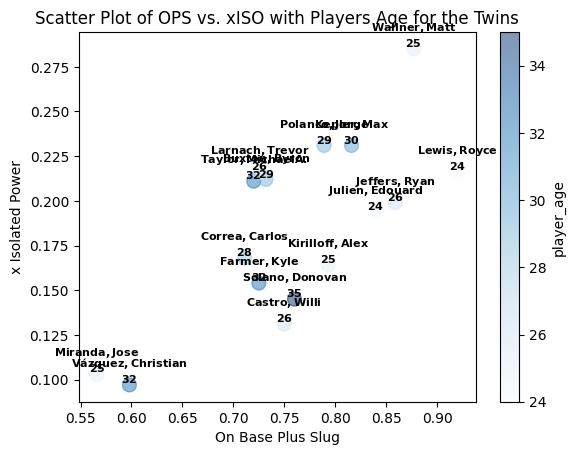

Points Breakdown for the Twins.
Wallner, Matt: 83 points
Kepler, Max: 72 points
Polanco, Jorge: 58 points
Lewis, Royce: 53 points
Buxton, Byron: 42 points
Larnach, Trevor: 36 points
Taylor, Michael A.: 35 points
Jeffers, Ryan: 34 points
Solano, Donovan: 32 points
Julien, Edouard: 31 points
Kirilloff, Alex: 18 points
Farmer, Kyle: 11 points
Correa, Carlos: 11 points
Castro, Willi: 8 points
Vázquez, Christian: 7 points

Player with the most points: Wallner, Matt with 83 points
Second place: Kepler, Max with 72 points
Third place: Polanco, Jorge with 58 points


For our analysis of the Twins we observe a few key results. Wallner, Matt is the our predicted key
contributors for the Twins the 2024 MLB season. Wallner, Matt contributes a large value to his team,
scoring high in numerous categories. Specifically Wallner, Matt placed in these categories:
Wallner, Matt is not in the top 5 for Run Value.
Wallner, Matt ranked 5 in Predicted xBatting Average 2024.
Wallner, Matt ranked 1 in xSLG 202

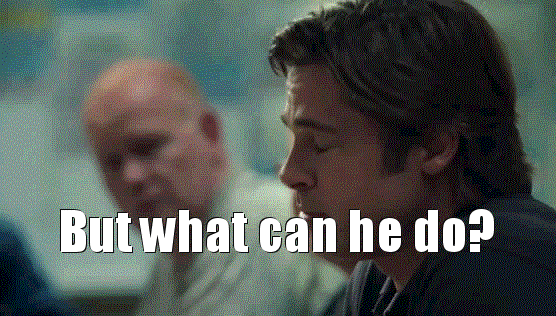

In [17]:
team_name = input("Enter a team to analyze: ")
generate_team_plots(team_name)
# Path to the local GIF file
gif_path = r'C:\Users\jsric\Downloads\He_Gets_On_Base.gif'
display(Image(filename=gif_path))

In [20]:
def analyze_all_teams(teams, all_player_points):
    for team in teams:
        print(f"\nAnalyzing {team}:")
        current_team = team
        
        filtered_data = data_plus_fielding[(data_plus_fielding['team'] == current_team) & (data_plus_fielding['year'] == 2023)]
        # Merge with extra_data
        team_df = pd.merge(filtered_data, extra_data, on=['player_id', 'year'], how='inner')

        # Rename columns
        team_df.rename(columns={'player_name_x': 'player_name', 'team_x': 'team'}, inplace=True)

        # Drop unnecessary columns
        team_df.drop(['player_name_y', 'team_y'], axis=1, inplace=True)
    ######################################################################################################################
        # Get the top 5 players in terms of run_value
        top10_run_value = team_df[team_df['run_value'] >= 0].sort_values(by='run_value', ascending=False).head(10).reset_index(drop=True)
   
        # Get the top 5 players in terms of outs
        top10_outs = team_df.sort_values(by='outs', ascending=False).head(10).reset_index(drop=True)
    ######################################################################################################################
        # Get the top 5 players in terms of x batting average
        top10_xbatting_average = team_df.sort_values(by='est_ba', ascending=False).head(10).reset_index(drop=True)
  
        # Get the top 5 players in terms of x batting average for 2024
        top10_x_batting_average_2024 = team_df.sort_values(by='predicted_est_ba', ascending=False).head(10).reset_index(
        drop=True)
    ######################################################################################################################
        # Get the top 5 players in terms of predicted_est_woba(advanced)
        top10_est_woba_2024 = team_df.sort_values(by='predicted_est_woba(advanced)', ascending=False).head(10).reset_index(
        drop=True)

        # Get the top 5 players in terms of xWOBA
        top10_est_woba = team_df.sort_values(by='est_woba', ascending=False).head(10).reset_index(drop=True)
    ######################################################################################################################
        # Get the top 5 players in terms of OPS for 2024
        top10_xops_2024 = team_df.sort_values(by='predicted_est_ops', ascending=False).head(10).reset_index(drop=True)

        # Get the top 5 players in terms of OPS
        top10_xops = team_df.sort_values(by='est_ops', ascending=False).head(10).reset_index(drop=True)
    ######################################################################################################################
        # Get the top 5 players in terms of xISO for 2024
        top10_xiso_2024 = team_df.sort_values(by='predicted_est_iso', ascending=False).head(10).reset_index(drop=True)

        # Get the top 5 players in terms of xISO
        top10_xiso = team_df.sort_values(by='est_iso', ascending=False).head(10).reset_index(drop=True)
    #######################################################################################################################
        # Get the top 5 players in terms of xSLG for 2024
        top10_xslg_2024 = team_df.sort_values(by='predicted_est_slg', ascending=False).head(10).reset_index(drop=True)

        # Get the top 5 players in terms of xSLG
        top10_xslg = team_df.sort_values(by='est_slg', ascending=False).head(10).reset_index(drop=True)
    ######################################################################################################################
        # Get the top 5 players in terms of Barrels per PA for 2024
        top10_brl_pa_2024 = team_df.sort_values(by='predicted_brl_pa', ascending=False).head(10).reset_index(drop=True)

        # Get the top 5 players in terms of Barrels per PA
        top10_brl_pa = team_df.sort_values(by='brl_pa', ascending=False).head(10).reset_index(drop=True)
    #####################################################################################################################
        # Get the top 5 players in terms of Average Hit Angle for 2024
        top10_avg_hit_angle_2024 = team_df.sort_values(by='predicted_avg_hit_angle', ascending=False).head(10).reset_index(
        drop=True)

        # Get the top 5 players in terms of Average Hit Angle
        top10_avg_hit_angle = team_df.sort_values(by='avg_hit_angle', ascending=False).head(10).reset_index(drop=True)
    #####################################################################################################################
        # Get the top 5 players in terms of Average Hit Speed for 2024
        top10_avg_hit_speed_2024 = team_df.sort_values(by='predicted_avg_hit_speed', ascending=False).head(10).reset_index(
        drop=True)

        # Get the top 5 players in terms of Average Hit Speed
        top10_avg_hit_speed = team_df.sort_values(by='avg_hit_speed', ascending=False).head(10).reset_index(drop=True)
    #####################################################################################################################
        # Get the top 5 players in terms of Average Hit Distance for 2024
        top10_avg_distance_2024 = team_df.sort_values(by='predicted_avg_distance', ascending=False).head(10).reset_index(
        drop=True)
    
        # Get the top 5 players in terms of Average Hit Distance
        top10_avg_distance = team_df.sort_values(by='avg_distance', ascending=False).head(10).reset_index(drop=True)
    ######################################################################################################################
        # Points Function
        player_points = {}

        def assign_points(top10_df):
            for idx, row in top10_df.iterrows():
                player_name = row['player_name']
                points = len(top10_df) - idx  # Ensure points are non-negative
                
                if player_name in player_points:
                    player_points[player_name] += points
                else:
                    player_points[player_name] = points

        # Assign points based on ranking
        assign_points(top10_run_value)
        assign_points(top10_x_batting_average_2024)
        assign_points(top10_xslg_2024)
        assign_points(top10_est_woba_2024)
        assign_points(top10_brl_pa_2024)
        assign_points(top10_avg_hit_angle_2024)
        assign_points(top10_avg_hit_speed_2024)
        assign_points(top10_avg_distance_2024)
        assign_points(top10_xops_2024)
        assign_points(top10_xiso_2024)

        second_player = None  # Initialize outside any block
        third_player = None  # Initialize outside any block

        # Display the total points for each player
        for player, points in sorted(player_points.items(), key=lambda x: x[1], reverse=True):
            all_player_points.update(player_points)
            pass
        if player_points:
            max_player, max_points = max(player_points.items(), key=lambda x: x[1])
            player_points.pop(max_player)  # Remove the player with the most points

            if player_points:
                second_player, second_points = max(player_points.items(), key=lambda x: x[1])

                player_points.pop(second_player)  # Remove the second-place player

                if player_points:
                    third_player, third_points = max(player_points.items(), key=lambda x: x[1])
        else:
            print("\nNo players to evaluate.")
    ######################################################################################################################
        def analyze_player_rankings(max_player, top10_run_value, top10_x_batting_average_2024, top10_xslg_2024,
                                    top10_est_woba_2024, top10_brl_pa_2024, top10_avg_hit_angle_2024, top10_avg_hit_speed_2024,
                                    top10_avg_distance_2024, top10_xops_2024, top10_xiso_2024):
            categories = {
                'Run Value': top10_run_value,
                'xBatting Average 2024': top10_x_batting_average_2024,
                'xSLG 2024': top10_xslg_2024,
                'Predicted xWOBA 2024': top10_est_woba_2024,
                'Barrels per PA 2024': top10_brl_pa_2024,
                'Average Hit Angle 2024': top10_avg_hit_angle_2024,
                'Average Hit Speed 2024': top10_avg_hit_speed_2024,
                'Average Distance 2024': top10_avg_distance_2024,
                'Predicted xOPS 2024': top10_xops_2024,
                'Predicted xISO 2024': top10_xiso_2024,
            }
    ###################################################################################################################
        # Create a podium visualization
        def display_podium(max_player, second_player, third_player):
            print(" -----Awards Podium------- ")

            max_len = 15
            second_len = 10
            third_len = 5

            first_player_data = all_data[all_data['player_name'] == max_player]
            second_player_data = all_data[all_data['player_name'] == second_player]
            third_player_data = all_data[all_data['player_name'] == third_player]
    
            # Extract the predicted_xba for the player
            predicted_first_place_xba = first_player_data['predicted_est_ba'].values[0]
            predicted_second_place_xba = second_player_data['predicted_est_ba'].values[0]
            predicted_third_place_xba = third_player_data['predicted_est_ba'].values[0]

            # Extract the predicted_xslg for the player
            predicted_first_place_xslg = first_player_data['predicted_est_slg'].values[0]
            predicted_second_place_xslg = second_player_data['predicted_est_slg'].values[0]
            predicted_third_place_xslg = third_player_data['predicted_est_slg'].values[0]

            # Extract the predicted_xwoba for the player
            predicted_first_place_xwoba = first_player_data['predicted_est_woba(advanced)'].values[0]
            predicted_second_place_xwoba = second_player_data['predicted_est_woba(advanced)'].values[0]
            predicted_third_place_xwoba = third_player_data['predicted_est_woba(advanced)'].values[0]
            
            # Print each place with a bar
            print(f""" 2nd: {('=' * second_len) + '|'} {second_player} xBA:{predicted_second_place_xba.round(3)} / xSLG:{predicted_second_place_xslg.round(3)} / xWOBA:{predicted_second_place_xwoba.round(3)}"""
                 )
            
            print(f""" 1st: {('=' * max_len) + '|'} {max_player} xBA:{predicted_first_place_xba.round(3)} / xSLG:{predicted_third_place_xslg.round(3)} / xWOBA:{predicted_first_place_xwoba.round(3)}"""
                 )
            
            print(f""" 3rd: {('=' * third_len) + '|'} {third_player} xBA:{predicted_third_place_xba.round(3)} / xSLG:{predicted_third_place_xslg.round(3)} / xWOBA:{predicted_third_place_xwoba.round(3)}"""
                 )
            print("\n" + "=" * 40 + "\n")

        display_podium(max_player, second_player, third_player)

In [21]:
def main():
    all_player_points = {}  # Dictionary to store points for all players
    teams = data_plus_fielding['team'].unique()
    # Ask the user if they want to analyze all teams
    user_response = input("Do you want to analyze all teams? (yes/no): ").lower()

    if user_response == 'yes':
        analyze_all_teams(teams, all_player_points)
       # Separate players by league
        american_league_players = {player: points for player, points in all_player_points.items() if get_league(player) == 'American League'}
        national_league_players = {player: points for player, points in all_player_points.items() if get_league(player) == 'National League'}

        print("\nPredicted Top Ten MVP Candidates for 2024 Players in the American League")
        print_top_players(american_league_players)

        print("\n" + "=" * 40 + "\n")
        
        print("\nPredicted Top Ten MVP Candidates for 2024 Players in the National League")
        print_top_players(national_league_players)
    else:
        print('whatever nerd')
        # Path to the local GIF file
        gif_path = r'C:\Users\jsric\Downloads\Whatever_Moneyball.gif'
        display(Image(filename=gif_path))

def get_league(player_name):
    return data_plus_fielding.loc[data_plus_fielding['player_name'] == player_name, 'League'].iloc[0]

def print_top_players(player_points):
    # Print the top players for a given dictionary of player points
    for player, points in sorted(player_points.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{player}: {points} points")


if __name__ == "__main__":
    main()

Do you want to analyze all teams? (yes/no):  yes



Analyzing Rangers:
 -----Awards Podium------- 
 2nd: ==========| García, Adolis xBA:0.263 / xSLG:0.514 / xWOBA:0.37
 1st: ===============| Seager, Corey xBA:0.315 / xSLG:0.466 / xWOBA:0.422
 3rd: =====| Jung, Josh xBA:0.268 / xSLG:0.466 / xWOBA:0.354



Analyzing Braves:
 -----Awards Podium------- 
 2nd: ==========| Olson, Matt xBA:0.286 / xSLG:0.526 / xWOBA:0.388
 1st: ===============| Ozuna, Marcell xBA:0.286 / xSLG:0.578 / xWOBA:0.401
 3rd: =====| Acuña Jr., Ronald xBA:0.338 / xSLG:0.578 / xWOBA:0.453



Analyzing Dodgers:
 -----Awards Podium------- 
 2nd: ==========| Martinez, J.D. xBA:0.278 / xSLG:0.531 / xWOBA:0.386
 1st: ===============| Ohtani, Shohei xBA:0.316 / xSLG:0.489 / xWOBA:0.431
 3rd: =====| Betts, Mookie xBA:0.31 / xSLG:0.489 / xWOBA:0.4



Analyzing Astros:
 -----Awards Podium------- 
 2nd: ==========| Diaz, Yainer xBA:0.287 / xSLG:0.499 / xWOBA:0.386
 1st: ===============| Alvarez, Yordan xBA:0.308 / xSLG:0.456 / xWOBA:0.426
 3rd: =====| Tucker, Kyle xBA:0.296 / xS